# RNN:Recurrent Neural Network

### RNN
* Recurrent Neural Network, 순환 신경망
* 과거의 행위가 다음 판단에 영향을 미치는 경우
* 고정 데이터가 아닌 순서가 있는 데이터
    * 예) 우와! 참 재밌네 vs 망할 참 재밌네!
* 구글 번역 서비스
    * Seq2Seq 신경망 모델
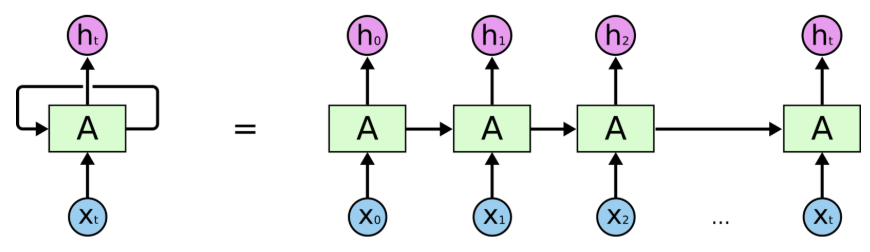

### 순환 신경망
* 시퀀스 데이터 처리할 수 있는 방법
    * RNN
    * 1D Convnet
* 주요 사례
    * 문서 분류, 시계열 분류
    * 감성분석
* 특징
    * 이전 상태 유지
    ```python
    state = 0
    for input in inputs:
        outout, state = rnn_cell(input, state)
    ```
*  RNN 구조 유형
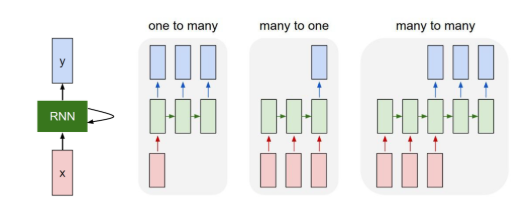
* RNN 개선
    * LSTM(Long Short Term Memory)
    * GRU

### Vanilla RNN
* 상태는 한개의 히든 벡터 H 로 구성
* $h_t = fw(h_{t-1}, x_t)$
    * $h_t = tanh(W_{hh}h_{t-1} + W_{xh}x_t + b_h)$
    * $ y_t = W_{hy}h_t + b_y $
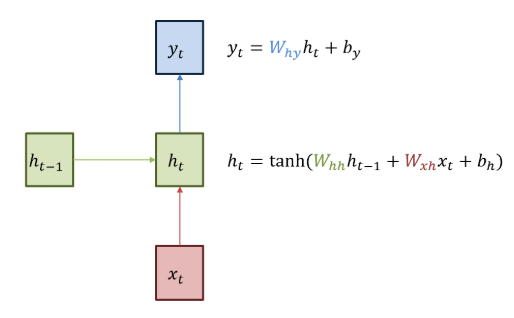
* 학습할 변수들
    * $W_{hx}$, $W_{hh}$, $b_h$
    * $W_{hy}$, $b_y$

### Vanilla RNN Graph
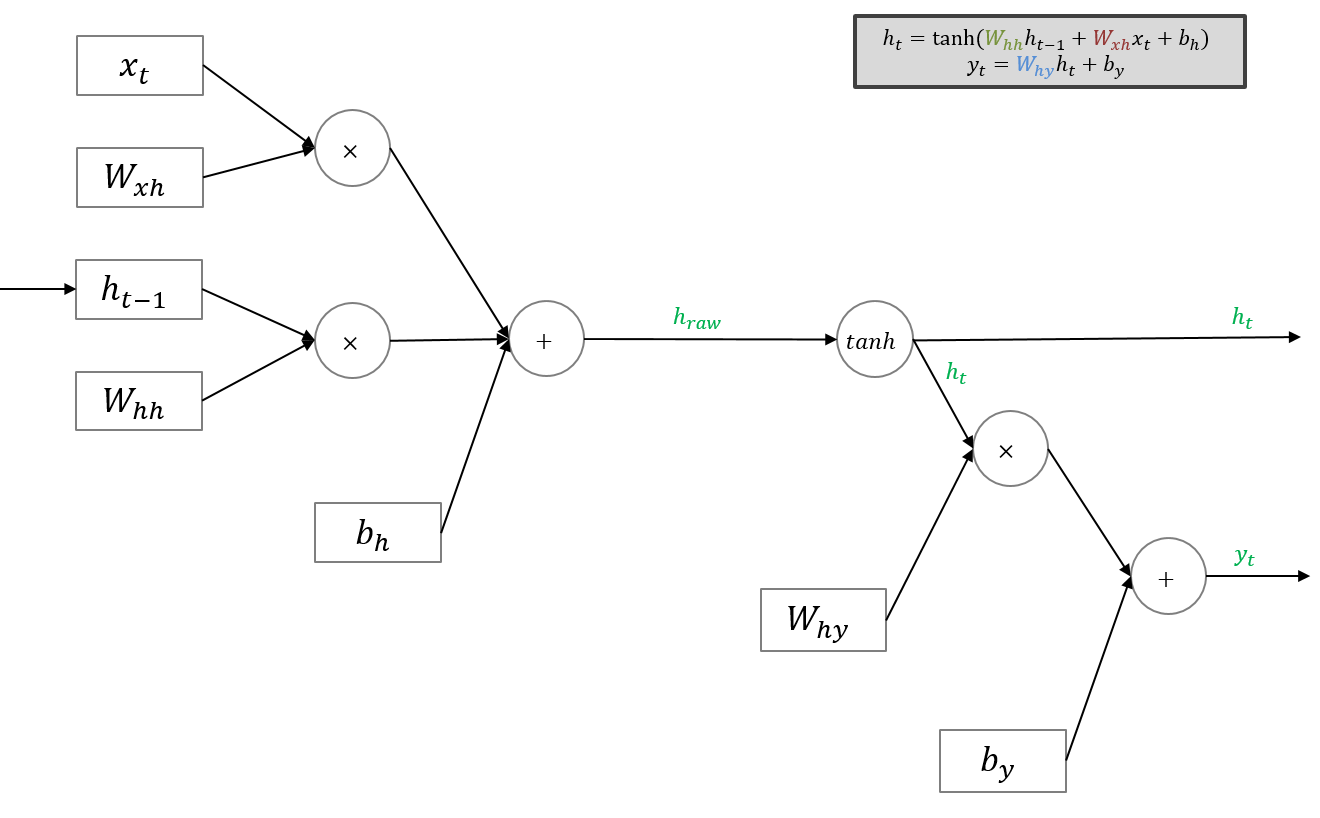

### Vanila RNN 실습
* RNN 구조를 직접 만들어 다음 글자 예측 실습
    * 입력 : "hihell"
    * 출력 : "ihello"
    * many to many
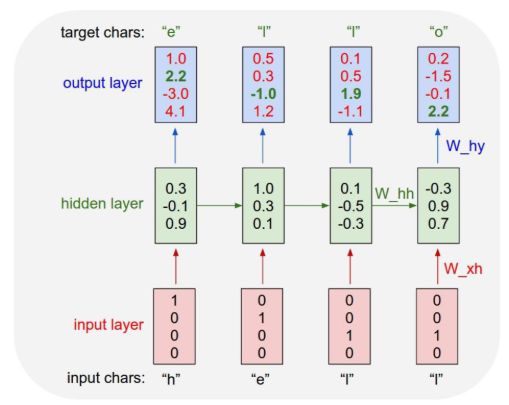

#### 입출력 데이타 준비

In [1]:
import tensorflow as tf
import numpy as np

sentence = "hihello"
x = "hihell"
y = "ihello"

voca = list({c for c in sentence})
dic = {c:i for i,c in enumerate(voca)}
dic2idx = {i:c for i, c in enumerate(voca)}
print(dic, dic2idx)

n_class = len(dic)  #example size
n_time_steps = len(x) #sequence
hidden_size = n_class #output size

x_idx = [dic[c] for c in x]
print("x_idx:", x_idx)
y_idx = [dic[c] for c in y]
print("y_idx:", y_idx)

x_enc =tf.keras.utils.to_categorical(x_idx, num_classes=n_class)
x_enc = np.expand_dims(x_enc, axis=0)
print("x_enc:", x_enc, x_enc.shape, )

y_enc = tf.keras.utils.to_categorical(y_idx, num_classes=n_class)
y_enc = np.expand_dims(y_enc, axis=0)
print("y_enc:", y_enc, y_enc.shape)

{'i': 0, 'h': 1, 'o': 2, 'l': 3, 'e': 4} {0: 'i', 1: 'h', 2: 'o', 3: 'l', 4: 'e'}
x_idx: [1, 0, 1, 4, 3, 3]
y_idx: [0, 1, 4, 3, 3, 2]
x_enc: [[[0. 1. 0. 0. 0.]
  [1. 0. 0. 0. 0.]
  [0. 1. 0. 0. 0.]
  [0. 0. 0. 0. 1.]
  [0. 0. 0. 1. 0.]
  [0. 0. 0. 1. 0.]]] (1, 6, 5)
y_enc: [[[1. 0. 0. 0. 0.]
  [0. 1. 0. 0. 0.]
  [0. 0. 0. 0. 1.]
  [0. 0. 0. 1. 0.]
  [0. 0. 0. 1. 0.]
  [0. 0. 1. 0. 0.]]] (1, 6, 5)


#### hidden state 준비

In [2]:

initializer =  tf.initializers.GlorotUniform() #xavier

Wx = tf.Variable(initializer([n_class, hidden_size]), name="Wx" )
Wh = tf.Variable(initializer([hidden_size, hidden_size]), name="Wh" )
bh = tf.Variable(initializer([hidden_size]), name="bias_h" )

#### hidden state 연산

In [3]:
def rnn_step(previous_hidden_state, x):
    current_hidden_state = tf.tanh(
        tf.matmul(previous_hidden_state, Wh) + 
        tf.matmul(x, Wx) + bh)
    return current_hidden_state


#### 출력 연산

In [4]:
Wy = tf.Variable(initializer([hidden_size, n_class]))
by = tf.Variable(initializer([n_class]))

def get_linear_layer(hidden_state):
    return tf.matmul(hidden_state, Wy) + by


#### 신경망 학습

* `tf.scan(fn, elemes)`
    * 모든 elemes를 순회하면서 fn에 전달
    * 이전 fn의 반환 값과 elemens의 다음 항목을 fn에 전달
    * 모든 fn의 반환 값을 리스트로 반환

In [21]:
# tf.scan() 사용 설명을 위한 예시
def f(prev, next):
    print(prev, next)
    return prev + next

data = np.arange(5).reshape(-1,1)+1
ret = tf.scan(f, data)
print(ret)

tf.Tensor([1], shape=(1,), dtype=int32) tf.Tensor([2], shape=(1,), dtype=int32)
tf.Tensor([3], shape=(1,), dtype=int32) tf.Tensor([3], shape=(1,), dtype=int32)
tf.Tensor([6], shape=(1,), dtype=int32) tf.Tensor([4], shape=(1,), dtype=int32)
tf.Tensor([10], shape=(1,), dtype=int32) tf.Tensor([5], shape=(1,), dtype=int32)
tf.Tensor(
[[ 1]
 [ 3]
 [ 6]
 [10]
 [15]], shape=(5, 1), dtype=int32)


In [6]:

learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
n_epoch = 500
for step in range(n_epoch):
    with tf.GradientTape() as tape:
        X_ = tf.transpose(x_enc, perm=[1, 0, 2])
        all_hidden_states = tf.scan(rnn_step, X_, name='states')#, initializer=init_hidden)
        all_outputs = tf.map_fn(get_linear_layer, all_hidden_states)
        cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=all_outputs, labels=y_enc))
    grads = tape.gradient(cost, [Wy, by, Wx, Wh,  bh])
    optimizer.apply_gradients(grads_and_vars=zip(grads, [Wy, by, Wx, Wh,  bh]))
    if (step+1) % 20 == 0:
            if step+ 1== n_epoch :
                print(all_outputs)
            prediction = tf.argmax(all_outputs, axis=2)
            print("step:{}, cost:{}, predict:{}, str:{}".format(step, cost, np.squeeze(prediction), [dic2idx[i] for i in np.squeeze(prediction)]))


step:19, cost:0.4918161630630493, predict:[4 1 4 3 3 2], str:['e', 'h', 'e', 'l', 'l', 'o']
step:39, cost:0.4634777009487152, predict:[4 1 4 3 3 2], str:['e', 'h', 'e', 'l', 'l', 'o']
step:59, cost:0.43818116188049316, predict:[4 1 4 3 3 2], str:['e', 'h', 'e', 'l', 'l', 'o']
step:79, cost:0.415355920791626, predict:[4 1 4 3 3 2], str:['e', 'h', 'e', 'l', 'l', 'o']
step:99, cost:0.3945654630661011, predict:[4 1 4 3 3 2], str:['e', 'h', 'e', 'l', 'l', 'o']
step:119, cost:0.37549057602882385, predict:[4 1 4 3 3 2], str:['e', 'h', 'e', 'l', 'l', 'o']
step:139, cost:0.3578891456127167, predict:[0 1 4 3 3 2], str:['i', 'h', 'e', 'l', 'l', 'o']
step:159, cost:0.3415720760822296, predict:[0 1 4 3 3 2], str:['i', 'h', 'e', 'l', 'l', 'o']
step:179, cost:0.3263883888721466, predict:[0 1 4 3 3 2], str:['i', 'h', 'e', 'l', 'l', 'o']
step:199, cost:0.31221526861190796, predict:[0 1 4 3 3 2], str:['i', 'h', 'e', 'l', 'l', 'o']
step:219, cost:0.29895174503326416, predict:[0 1 4 3 3 2], str:['i', 'h',

### TF RNN API
* `cell = tf.keras.layers..rnn_cell.SimpleRNNCell(units=hidden_size)`
    * RNN 구현을 위해 필요한 변수 선언 및 구조 제공
    * `hidden_size` : output, state size
* `rnn = tf.keras.layers.RNN(cell,return_sequences=True, return_state=True)`
* `outputs, states = rnn(X)`
    * rnn_cell을 전달 받아 반복(tf.scan()) 연산해서 output과 state 계산
    * rnn.trainable_variables : 학습할 변수 얻기
* `rnn = tf.keras.layers..rnn_cell.SimpleRNNCell(units=hidden_size, return_sequences=True, return_state=True)`
    * SimpleRNNCell + RNN
    * Cell과 RNN 역할을 동시에 수행

In [58]:
import tensorflow as tf
import numpy as np


x_data = np.array([[[1,2,3,4],
                    [5,6,7,8]]], dtype=np.float32) #(1,2,4) : (batch, time_step, depth)
print(x_data.shape)

hidden_size = 2
cell = tf.keras.layers.SimpleRNNCell(hidden_size)

print(cell.output_size, cell.state_size)
rnn = tf.keras.layers.RNN(cell, return_sequences=True, return_state=True)
outputs, return_state = rnn(x_data)
print(outputs, return_state)
print(rnn.trainable_variables)


(1, 2, 4)
2 2
tf.Tensor(
[[[-0.9994423  -0.99614716]
  [-0.99999994 -0.99995637]]], shape=(1, 2, 2), dtype=float32) tf.Tensor([[-0.99999994 -0.99995637]], shape=(1, 2), dtype=float32)
[<tf.Variable 'rnn_539/kernel:0' shape=(4, 2) dtype=float32, numpy=
array([[-0.7454972 ,  0.45575047],
       [ 0.47525835, -0.0815351 ],
       [-0.43057346, -0.42226315],
       [-0.7513912 , -0.53774214]], dtype=float32)>, <tf.Variable 'rnn_539/recurrent_kernel:0' shape=(2, 2) dtype=float32, numpy=
array([[-0.7573272 ,  0.6530357 ],
       [-0.6530357 , -0.75732714]], dtype=float32)>, <tf.Variable 'rnn_539/bias:0' shape=(2,) dtype=float32, numpy=array([0., 0.], dtype=float32)>]


#### TF RNN API로 "hi hello" 구현

In [14]:
import tensorflow as tf
import numpy as np

sentence = "hihello"
x = "hihell"
y = "ihello"

voca = list({c for c in sentence})
dic = {c:i for i,c in enumerate(voca)}
dic2idx = {i:c for i, c in enumerate(voca)}
print(dic, dic2idx)

n_class = len(dic)  #example size
n_time_steps = len(x) #sequence
hidden_size = n_class #output size

x_idx = [dic[c] for c in x]
print("x_idx:", x_idx)
y_idx = [dic[c] for c in y]
print("y_idx:", y_idx)

x_enc =tf.keras.utils.to_categorical(x_idx, num_classes=n_class)
x_enc = np.expand_dims(x_enc, axis=0)
print("x_enc:", x_enc, x_enc.shape, )

y_enc = tf.keras.utils.to_categorical(y_idx, num_classes=n_class)
y_enc = np.expand_dims(y_enc, axis=0)
print("y_enc:", y_enc, y_enc.shape)

{'i': 0, 'h': 1, 'o': 2, 'l': 3, 'e': 4} {0: 'i', 1: 'h', 2: 'o', 3: 'l', 4: 'e'}
x_idx: [1, 0, 1, 4, 3, 3]
y_idx: [0, 1, 4, 3, 3, 2]
x_enc: [[[0. 1. 0. 0. 0.]
  [1. 0. 0. 0. 0.]
  [0. 1. 0. 0. 0.]
  [0. 0. 0. 0. 1.]
  [0. 0. 0. 1. 0.]
  [0. 0. 0. 1. 0.]]] (1, 6, 5)
y_enc: [[[1. 0. 0. 0. 0.]
  [0. 1. 0. 0. 0.]
  [0. 0. 0. 0. 1.]
  [0. 0. 0. 1. 0.]
  [0. 0. 0. 1. 0.]
  [0. 0. 1. 0. 0.]]] (1, 6, 5)


In [54]:
initializer =  tf.initializers.GlorotUniform() #xavier
Wy = tf.Variable(initializer([hidden_size, n_class]))
by = tf.Variable(initializer([n_class]))

def get_linear_layer(hidden_state):
    return tf.matmul(hidden_state, Wy) + by


learning_rate = 0.1
#cell = tf.keras.layers.SimpleRNNCell(hidden_size)
#rnn = tf.keras.layers.RNN(cell, return_sequences=True, return_state=True)
rnn = tf.keras.layers.SimpleRNN(hidden_size, return_sequences=True, return_state=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
n_epoch = 500
for step in range(n_epoch):
    with tf.GradientTape() as tape:
        outputs, states = rnn(x_enc)
        all_outputs = tf.map_fn(get_linear_layer, outputs)
        variables = rnn.trainable_variables + [Wy, by]
        cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=all_outputs, labels=y_enc))
    grads = tape.gradient(cost, variables)
    optimizer.apply_gradients(zip(grads, variables))
    if (step+1) % 20 == 0:
        prediction = tf.argmax(all_outputs, axis=2)
        print("step:{}, cost:{}, predict:{}, str:{}".format(step, cost, np.squeeze(prediction), [dic2idx[i] for i in np.squeeze(prediction)]))                 

step:19, cost:0.3844352662563324, predict:[0 1 4 3 3 2], str:['i', 'h', 'e', 'l', 'l', 'o']
step:39, cost:0.11241928488016129, predict:[0 1 4 3 3 2], str:['i', 'h', 'e', 'l', 'l', 'o']
step:59, cost:0.05669059976935387, predict:[0 1 4 3 3 2], str:['i', 'h', 'e', 'l', 'l', 'o']
step:79, cost:0.03752041235566139, predict:[0 1 4 3 3 2], str:['i', 'h', 'e', 'l', 'l', 'o']
step:99, cost:0.02785954624414444, predict:[0 1 4 3 3 2], str:['i', 'h', 'e', 'l', 'l', 'o']
step:119, cost:0.021878572180867195, predict:[0 1 4 3 3 2], str:['i', 'h', 'e', 'l', 'l', 'o']
step:139, cost:0.01779205910861492, predict:[0 1 4 3 3 2], str:['i', 'h', 'e', 'l', 'l', 'o']
step:159, cost:0.014837165363132954, predict:[0 1 4 3 3 2], str:['i', 'h', 'e', 'l', 'l', 'o']
step:179, cost:0.012614771723747253, predict:[0 1 4 3 3 2], str:['i', 'h', 'e', 'l', 'l', 'o']
step:199, cost:0.01089258212596178, predict:[0 1 4 3 3 2], str:['i', 'h', 'e', 'l', 'l', 'o']
step:219, cost:0.009525617584586143, predict:[0 1 4 3 3 2], str

## LSTM
* Long Short-Term Memory Unit
* Hochreiter(1997) 제안, RNN 변형 
* 자연어 처리 분야 딥러닝 기법 중 가장 활발히 사용
* RNN의 맨 뒤에서 맨 앞의 정보를 기억하지 못하는 특성 보완
* RNN의 Hidden state에 cell-state를 추가
* 오차의 그라디언트가 시간을 거슬러 잘 흘러갈 수 있다.
* 1000단계가 넘는 Backpropagation 과정에서 오차 값 유지
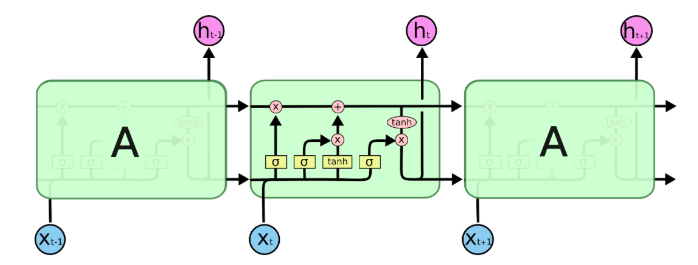

* Hidden Layer를 4개의 계층으로 구성
    * Cell State : 이전 정보를 다음 단계로 전달, 3가지 게이트에 의해 전달 여부 결정
    * Forget Gate : 기존 Cell State에서 어떠한 정보를 지울 지 결정
    * Input Gate : Cell State에 저장할 새로운 정보를 결정
    * Output Gate : Cell State 값을 다음 상태로 출력할 지 결정

### GRUCell
* Gated Recurrent Units
* 2014 뉴욕대 조경현 교수 제안
* LSTM의 변형, 더 간단한 구조
* 게이트 된 순환 유닛(Gate Recurrent Unit)
* 잊기와 입력 게이트들을 하나의 단일 Update 게이트로 통합
* 셀 상태와 숨겨진 상태 통합
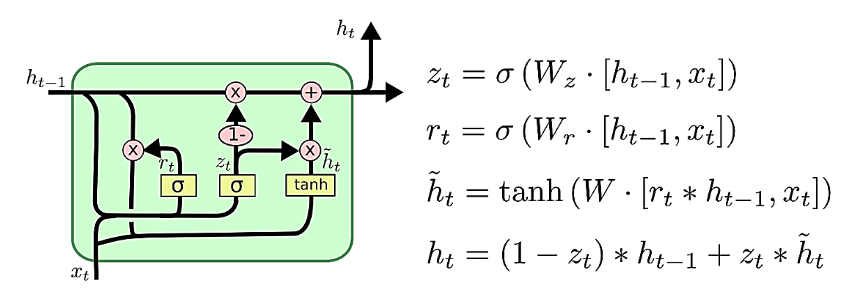

### LSTM/GRU를 이용한 "hihello" 실습
* `tf.keras.layers.LSTMCell()`
* `tf.keras.layers.LSTM()`
* `tf.keras.layers.GRUCell()`
* `tf.keras.layers.GRU()`

In [78]:
import tensorflow as tf
import numpy as np

sentence = "hihello"
x = "hihell"
y = "ihello"

voca = list({c for c in sentence})
dic = {c:i for i,c in enumerate(voca)}
dic2idx = {i:c for i, c in enumerate(voca)}
print(dic, dic2idx)

n_class = len(dic)  #example size
n_time_steps = len(x) #sequence
hidden_size = n_class #output size

x_idx = [dic[c] for c in x]
print("x_idx:", x_idx)
y_idx = [dic[c] for c in y]
print("y_idx:", y_idx)

x_enc =tf.keras.utils.to_categorical(x_idx, num_classes=n_class)
x_enc = np.expand_dims(x_enc, axis=0)
print("x_enc:", x_enc, x_enc.shape, )

y_enc = tf.keras.utils.to_categorical(y_idx, num_classes=n_class)
y_enc = np.expand_dims(y_enc, axis=0)
print("y_enc:", y_enc, y_enc.shape)


############# Cell Selecte ##############################
#cell = tf.keras.layers.LSTMCell(hidden_size)
cell = tf.keras.layers.GRUCell(hidden_size)
#rnn = tf.keras.layers.RNN(cell, return_sequences=True)
#rnn = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
rnn = tf.keras.layers.GRU(hidden_size, return_sequences=True)

initializer =  tf.initializers.GlorotUniform() #xavier
Wy = tf.Variable(initializer([hidden_size, n_class]))
by = tf.Variable(initializer([n_class]))

def get_linear_layer(hidden_state):
    return tf.matmul(hidden_state, Wy) + by

learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
prediction = tf.argmax(all_outputs, axis=2)

n_epoch = 1000
for step in range(n_epoch):
    with tf.GradientTape() as tape:
        outputs = rnn(x_enc)
        all_outputs = tf.map_fn(get_linear_layer, outputs)
        cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=all_outputs, labels=y_enc))
    grads = tape.gradient(cost, rnn.trainable_variables + [Wy, by])
    optimizer.apply_gradients(zip(grads, rnn.trainable_variables + [Wy, by]))
    if (step+1) % 20 == 0:
        prediction = tf.argmax(all_outputs, axis=2)
        print("step:{}, cost:{}, predict:{}, str:{}".format(step, cost, np.squeeze(prediction), [dic2idx[i] for i in np.squeeze(prediction)]))                                

{'i': 0, 'h': 1, 'o': 2, 'l': 3, 'e': 4} {0: 'i', 1: 'h', 2: 'o', 3: 'l', 4: 'e'}
x_idx: [1, 0, 1, 4, 3, 3]
y_idx: [0, 1, 4, 3, 3, 2]
x_enc: [[[0. 1. 0. 0. 0.]
  [1. 0. 0. 0. 0.]
  [0. 1. 0. 0. 0.]
  [0. 0. 0. 0. 1.]
  [0. 0. 0. 1. 0.]
  [0. 0. 0. 1. 0.]]] (1, 6, 5)
y_enc: [[[1. 0. 0. 0. 0.]
  [0. 1. 0. 0. 0.]
  [0. 0. 0. 0. 1.]
  [0. 0. 0. 1. 0.]
  [0. 0. 0. 1. 0.]
  [0. 0. 1. 0. 0.]]] (1, 6, 5)
tf.Tensor(
[[[-0.04201068 -0.2308494  -0.34743926 -0.72026116 -0.20250842]
  [ 0.2650448  -0.31924137 -0.15559393 -0.23370704 -0.01336295]
  [ 0.07516631 -0.19220114 -0.3209464  -0.6435027  -0.21836154]
  [ 0.00161713 -0.44343773 -0.18861514 -0.1969923   0.03542368]
  [ 0.29613674 -0.41550517 -0.09435843 -0.30844167  0.18968469]
  [ 0.40342394 -0.40766126 -0.0544681  -0.35135543  0.2497499 ]]], shape=(1, 6, 5), dtype=float32)
tf.Tensor(
[[[-4.2912453e-02 -2.3164785e-01 -3.4774643e-01 -7.1763909e-01
   -2.0180538e-01]
  [ 2.6291847e-01 -3.1778297e-01 -1.5694112e-01 -2.3007327e-01
   -1.5976507e

  [ 0.3444189  -0.4083332  -0.00074472 -0.19934154  0.24396408]]], shape=(1, 6, 5), dtype=float32)
tf.Tensor(
[[[-0.06189521 -0.24663463 -0.35461634 -0.6695292  -0.18755189]
  [ 0.2182931  -0.28496882 -0.184162   -0.14140049 -0.07243777]
  [ 0.04180574 -0.20881842 -0.316445   -0.54640436 -0.21126848]
  [-0.0300028  -0.43908024 -0.19100994 -0.03606296  0.01176849]
  [ 0.2423623  -0.41165924 -0.05503301 -0.14957276  0.17431326]
  [ 0.34174937 -0.40823418  0.00186357 -0.19220203  0.24357307]]], shape=(1, 6, 5), dtype=float32)
tf.Tensor(
[[[-0.06268603 -0.24714695 -0.35493335 -0.6674006  -0.18696782]
  [ 0.21639831 -0.2833715  -0.1853116  -0.13719639 -0.07501202]
  [ 0.04044203 -0.20938104 -0.31609094 -0.5421072  -0.21097556]
  [-0.03137223 -0.43867683 -0.19090587 -0.02872562  0.01060693]
  [ 0.23999882 -0.41140354 -0.05305091 -0.14232935  0.17358403]
  [ 0.3390834  -0.40812868  0.00449005 -0.18503812  0.24317321]]], shape=(1, 6, 5), dtype=float32)
tf.Tensor(
[[[-0.06346725 -0.24764167 -0.

tf.Tensor(
[[[-0.07975182 -0.253942   -0.36262247 -0.61094844 -0.17230761]
  [ 0.17055668 -0.23512875 -0.21259996 -0.02482811 -0.14579809]
  [ 0.00861557 -0.21851577 -0.2986342  -0.42456248 -0.20222847]
  [-0.07228385 -0.42194605 -0.18184339  0.18130335 -0.02680904]
  [ 0.1746886  -0.40471703  0.00836414  0.06537586  0.15114059]
  [ 0.26770523 -0.4062844   0.08285353  0.01897672  0.23000702]]], shape=(1, 6, 5), dtype=float32)
tf.Tensor(
[[[-0.08022811 -0.2539187  -0.36283988 -0.6089363  -0.17176993]
  [ 0.16902426 -0.23319277 -0.21347082 -0.02076396 -0.14843175]
  [ 0.00758769 -0.21867079 -0.29763427 -0.42018637 -0.20180196]
  [-0.07402954 -0.42121848 -0.18127538  0.18957746 -0.02839938]
  [ 0.17213905 -0.40460283  0.01091585  0.07356995  0.15022904]
  [ 0.26499686 -0.40639257  0.086036    0.02697155  0.2294695 ]]], shape=(1, 6, 5), dtype=float32)
tf.Tensor(
[[[-0.08069508 -0.25387472 -0.36305043 -0.60693383 -0.17123038]
  [ 0.16750015 -0.2312495  -0.21433629 -0.01670611 -0.15106459]
 

tf.Tensor(
[[[-0.09011491 -0.2448178  -0.36668074 -0.55858105 -0.15568492]
  [ 0.12860218 -0.17625858 -0.2385649   0.09100264 -0.221807  ]
  [-0.02049867 -0.21991135 -0.26060236 -0.29921824 -0.18500918]
  [-0.13066953 -0.40224838 -0.16145706  0.43703768 -0.07864054]
  [ 0.09262716 -0.40968892  0.08871299  0.32025167  0.12367829]
  [ 0.18117744 -0.41922826  0.18260235  0.2662898   0.21490788]]], shape=(1, 6, 5), dtype=float32)
tf.Tensor(
[[[-0.0903514  -0.24419734 -0.36679813 -0.55708134 -0.15507574]
  [ 0.12722844 -0.17411114 -0.23958328  0.09492123 -0.22442567]
  [-0.02152146 -0.21987197 -0.25903866 -0.2950153  -0.1842406 ]
  [-0.1329752  -0.40164143 -0.16067716  0.44640863 -0.08065418]
  [ 0.08945576 -0.41016662  0.09171271  0.3296975   0.12271942]
  [ 0.17783412 -0.42003715  0.18632865  0.27541935  0.21444158]]], shape=(1, 6, 5), dtype=float32)
tf.Tensor(
[[[-0.09057996 -0.24355713 -0.36692068 -0.5556085  -0.15446493]
  [ 0.12585945 -0.17195323 -0.24061525  0.0988324  -0.22704571]
 

  [ 0.06895161 -0.45346218  0.30560237  0.5525665   0.20495331]]], shape=(1, 6, 5), dtype=float32)
tf.Tensor(
[[[-0.0933929  -0.21643184 -0.37614843 -0.52871287 -0.13603765]
  [ 0.08909721 -0.10349339 -0.27815056  0.20502585 -0.30366877]
  [-0.0537629  -0.21611917 -0.21081477 -0.18052311 -0.1566487 ]
  [-0.21130471 -0.3855616  -0.13786976  0.73652136 -0.14873657]
  [-0.01711687 -0.43329     0.1910463   0.62707293  0.09585186]
  [ 0.06479743 -0.45497692  0.31017202  0.56227577  0.20483145]]], shape=(1, 6, 5), dtype=float32)
tf.Tensor(
[[[-0.09334261 -0.21520983 -0.37676394 -0.528486   -0.13535646]
  [ 0.08796471 -0.10089253 -0.2797714   0.20825738 -0.30631933]
  [-0.05487035 -0.21589983 -0.2092855  -0.1773493  -0.15555838]
  [-0.21420114 -0.38510385 -0.13717476  0.7462169  -0.15123868]
  [-0.02103559 -0.43437177  0.19472516  0.63714963  0.09509034]
  [ 0.06062023 -0.4565174   0.3147776   0.57196945  0.20472914]]], shape=(1, 6, 5), dtype=float32)
tf.Tensor(
[[[-0.0932814  -0.21397021 -0.

tf.Tensor(
[[[-0.08741275 -0.17673427 -0.40295815 -0.5459874  -0.11295766]
  [ 0.06268253 -0.02353477 -0.33501372  0.27565163 -0.3766284 ]
  [-0.08344849 -0.20806968 -0.17396393 -0.11908576 -0.11931272]
  [-0.2970725  -0.37475714 -0.12220827  0.99499655 -0.2223565 ]
  [-0.13282482 -0.47230595  0.30472648  0.89526117  0.08202432]
  [-0.05832281 -0.5081191   0.45288402  0.8175726   0.21137327]]], shape=(1, 6, 5), dtype=float32)
step:139, cost:1.2971009016036987, predict:[0 3 0 3 3 3], str:['i', 'l', 'i', 'l', 'l', 'l']
tf.Tensor(
[[[-0.08700413 -0.17516488 -0.40425843 -0.54755825 -0.11190166]
  [ 0.06198733 -0.02039242 -0.33753845  0.27728352 -0.3791554 ]
  [-0.08440182 -0.20772877 -0.17291266 -0.11808035 -0.11766176]
  [-0.30024865 -0.37443078 -0.12183805  1.0035357  -0.22508642]
  [-0.13710599 -0.4740467   0.30918106  0.9040158   0.08188378]
  [-0.06285552 -0.5104043   0.45847383  0.8257371   0.21202824]]], shape=(1, 6, 5), dtype=float32)
tf.Tensor(
[[[-0.08658059 -0.1735898  -0.405578

tf.Tensor(
[[[-0.0682252  -0.12884243 -0.4490553  -0.62086016 -0.0702027 ]
  [ 0.05174658  0.07982543 -0.42847434  0.2944455  -0.44906166]
  [-0.10559204 -0.19732493 -0.15218128 -0.1266019  -0.05849775]
  [-0.39193746 -0.36538547 -0.12005341  1.2246045  -0.30621   ]
  [-0.26141492 -0.53545994  0.44635427  1.1238158   0.08979318]
  [-0.1926681  -0.5881659   0.6297841   1.0212342   0.24505177]]], shape=(1, 6, 5), dtype=float32)
tf.Tensor(
[[[-0.06732649 -0.12726855 -0.450798   -0.62428343 -0.06834433]
  [ 0.05176375  0.08359739 -0.43227053  0.29401088 -0.4513573 ]
  [-0.10606023 -0.1969576  -0.15186374 -0.12813452 -0.0560853 ]
  [-0.39504054 -0.36507875 -0.1203751   1.231313   -0.30907857]
  [-0.26567066 -0.5379689   0.45122725  1.1302559   0.0904251 ]
  [-0.19702774 -0.5912532   0.6358558   1.0265377   0.24663404]]], shape=(1, 6, 5), dtype=float32)
tf.Tensor(
[[[-0.06641049 -0.12569869 -0.4525519  -0.62776124 -0.06645693]
  [ 0.05180675  0.08739041 -0.43611357  0.2935113  -0.45364588]
 

tf.Tensor(
[[[-0.03515337 -0.08521403 -0.50388885 -0.73996437 -0.00488287]
  [ 0.06262957  0.19757569 -0.5579494   0.25773835 -0.5130049 ]
  [-0.11131012 -0.1867832  -0.15687658 -0.19802871  0.01932499]
  [-0.4797893  -0.35775584 -0.14225227  1.3986638  -0.39179906]
  [-0.38447225 -0.6197035   0.58412206  1.2905746   0.11096888]
  [-0.3154     -0.6901247   0.80357444  1.1445951   0.29784444]]], shape=(1, 6, 5), dtype=float32)
tf.Tensor(
[[[-0.03375642 -0.0837929  -0.5059296  -0.74470884 -0.0022283 ]
  [ 0.06337799  0.20193683 -0.5631306   0.25568926 -0.5151182 ]
  [-0.11122325 -0.18643996 -0.15757054 -0.20132968  0.02226549]
  [-0.48275402 -0.3575843  -0.14348993  1.4040346  -0.39483714]
  [-0.38873094 -0.6230446   0.5886476   1.2958548   0.1116429 ]
  [-0.31950232 -0.6941265   0.80942845  1.1479428   0.29980233]]], shape=(1, 6, 5), dtype=float32)
step:199, cost:1.1308107376098633, predict:[4 3 4 3 3 3], str:['e', 'l', 'e', 'l', 'l', 'l']
tf.Tensor(
[[[-3.2342665e-02 -8.2377590e-02 -5.

tf.Tensor(
[[[ 0.01392152 -0.04498896 -0.56885135 -0.89546573  0.08496219]
  [ 0.09451214  0.33660623 -0.73305035  0.18085003 -0.573635  ]
  [-0.10160012 -0.1790475  -0.19054297 -0.3122201   0.11499326]
  [-0.5682182  -0.35786173 -0.19040786  1.5491867  -0.484422  ]
  [-0.51303846 -0.73225963  0.713464    1.4460837   0.12278508]
  [-0.43256104 -0.8230899   0.9771726   1.2259449   0.3550164 ]]], shape=(1, 6, 5), dtype=float32)
tf.Tensor(
[[[ 0.01580906 -0.04372392 -0.57114017 -0.901036    0.08829023]
  [ 0.09587612  0.34152463 -0.7395601   0.17787084 -0.5755512 ]
  [-0.10105371 -0.17892875 -0.1920328  -0.3164211   0.11847302]
  [-0.571173   -0.35807973 -0.19234517  1.553953   -0.4875369 ]
  [-0.5173253  -0.7364181   0.7176266   1.4512304   0.1228255 ]
  [-0.436161   -0.8278872   0.98297     1.2279849   0.35679197]]], shape=(1, 6, 5), dtype=float32)
tf.Tensor(
[[[ 0.01771284 -0.04246257 -0.57343656 -0.9066265   0.09163743]
  [ 0.09725713  0.3464609  -0.74611145  0.1748728  -0.5774598 ]
 

tf.Tensor(
[[[ 0.07528527 -0.0092286  -0.6383499  -1.0637348   0.1882262 ]
  [ 0.14025523  0.48628598 -0.93784946  0.08882803 -0.62579787]
  [-0.08145539 -0.18125495 -0.23941606 -0.43875432  0.2244176 ]
  [-0.6550937  -0.3698076  -0.25363496  1.68554    -0.574421  ]
  [-0.6357403  -0.8608439   0.83373404  1.5948417   0.1134507 ]
  [-0.5242222  -0.964791    1.1474687   1.2670662   0.39907506]]], shape=(1, 6, 5), dtype=float32)
tf.Tensor(
[[[ 0.07764954 -0.00800369 -0.6408658  -1.0697362   0.19199371]
  [ 0.14203572  0.491696   -0.9454628   0.08550742 -0.6274503 ]
  [-0.08062444 -0.18156438 -0.24126267 -0.44322813  0.22850758]
  [-0.6581434  -0.37041134 -0.256071    1.6902137  -0.577492  ]
  [-0.6398904  -0.8655155   0.8378855   1.5999434   0.11272735]
  [-0.5268584  -0.96963733  1.1533924   1.267841    0.40023848]]], shape=(1, 6, 5), dtype=float32)
tf.Tensor(
[[[ 0.08003058 -0.00677735 -0.64339006 -1.0757478   0.19577175]
  [ 0.14382815  0.49712157 -0.95310944  0.08218031 -0.6290914 ]
 

tf.Tensor(
[[[ 0.15649801  0.03014916 -0.72018635 -1.253277    0.3085205 ]
  [ 0.20054258  0.6605206  -1.1872437  -0.01653956 -0.671017  ]
  [-0.05243677 -0.19923793 -0.29930285 -0.57888496  0.36064148]
  [-0.7514278  -0.39341453 -0.33719638  1.8294597  -0.66693795]
  [-0.76080906 -1.0089486   0.9611963   1.7512476   0.07800917]
  [-0.5883678  -1.106194    1.3282087   1.2747393   0.41965115]]], shape=(1, 6, 5), dtype=float32)
tf.Tensor(
[[[ 0.15939274  0.03149325 -0.7229537  -1.2594712   0.31246978]
  [ 0.20265019  0.66634077 -1.1956658  -0.02000804 -0.67224884]
  [-0.05139548 -0.20011957 -0.3012884  -0.5834489   0.36534628]
  [-0.7545885  -0.39432463 -0.3401728   1.834032   -0.66980016]
  [-0.7647011  -1.0137614   0.9652066   1.7562132   0.07641996]
  [-0.5898383  -1.1103472   1.3338413   1.2745064   0.41974008]]], shape=(1, 6, 5), dtype=float32)
tf.Tensor(
[[[ 0.16230474  0.03284348 -0.7257284  -1.2656678   0.31642017]
  [ 0.20476758  0.6721719  -1.2041055  -0.0234808  -0.6734654 ]
 

tf.Tensor(
[[[ 0.24735641  0.07190681 -0.8029828  -1.4331423   0.42237562]
  [ 0.2655731   0.8332377  -1.4365499  -0.11881632 -0.70063704]
  [-0.01940696 -0.23250681 -0.35643616 -0.71261275  0.50389487]
  [-0.8435847  -0.4223918  -0.43086314  1.9580392  -0.74593276]
  [-0.8693122  -1.1460181   1.0716395   1.892322    0.02189927]
  [-0.617221   -1.2135588   1.4828072   1.259493    0.40857857]]], shape=(1, 6, 5), dtype=float32)
tf.Tensor(
[[[ 0.25073844  0.07345741 -0.80591184 -1.4393224   0.42623574]
  [ 0.26795965  0.83931893 -1.4452504  -0.12240705 -0.70143944]
  [-0.01815476 -0.23392928 -0.35835692 -0.7172767   0.50905997]
  [-0.84676296 -0.42346326 -0.43436563  1.9622942  -0.74850476]
  [-0.87288904 -1.1506109   1.0751799   1.897071    0.01964061]
  [-0.6177502  -1.2167807   1.4877838   1.2587068   0.4077645 ]]], shape=(1, 6, 5), dtype=float32)
tf.Tensor(
[[[ 0.25413638  0.07501569 -0.8088442  -1.4454987   0.43008852]
  [ 0.27035582  0.84540707 -1.4539521  -0.12600209 -0.7022281 ]
 

tf.Tensor(
[[[ 0.35530746  0.12162104 -0.8915645  -1.6160867   0.5340041 ]
  [ 0.34122896  1.0180568  -1.6959156  -0.22812176 -0.7193185 ]
  [ 0.0218624  -0.282208   -0.4106869  -0.85318017  0.6634274 ]
  [-0.9380477  -0.45539573 -0.5434099   2.080016   -0.8189614 ]
  [-0.97236854 -1.2787745   1.1679935   2.031863   -0.05182885]
  [-0.6227339  -1.2986902   1.6220319   1.2306846   0.37754893]]], shape=(1, 6, 5), dtype=float32)
tf.Tensor(
[[[ 0.35911784  0.12338357 -0.89451385 -1.6220658   0.5375396 ]
  [ 0.343889    1.0242771  -1.7044269  -0.23180789 -0.719774  ]
  [ 0.02337195 -0.28409305 -0.41234154 -0.85785335  0.6688669 ]
  [-0.94115466 -0.45650917 -0.5474094   2.0838947  -0.8212582 ]
  [-0.9756718  -1.2830192   1.1708353   2.0364313  -0.05443349]
  [-0.62260604 -1.3011843   1.6263455   1.2295647   0.37639475]]], shape=(1, 6, 5), dtype=float32)
tf.Tensor(
[[[ 0.3629404   0.12515219 -0.8974612  -1.6280348   0.54106045]
  [ 0.3465574   1.0304992  -1.7129247  -0.23549548 -0.72022057]
 

  [-0.6138804  -1.3633026   1.7368697   1.1961142   0.34699714]]], shape=(1, 6, 5), dtype=float32)
tf.Tensor(
[[[ 0.47020614  0.17479934 -0.97554636 -1.7849851   0.6300703 ]
  [ 0.4214505   1.1986719  -1.9360464  -0.33516768 -0.7295458 ]
  [ 0.06893171 -0.34154648 -0.45320374 -0.98606294  0.8221746 ]
  [-1.026761   -0.48731184 -0.66462195  2.1888711  -0.8823773 ]
  [-1.0658429  -1.3974643   1.2404604   2.1634028  -0.12818135]
  [-0.61339575 -1.3654604   1.7407827   1.194761    0.34603864]]], shape=(1, 6, 5), dtype=float32)
tf.Tensor(
[[[ 0.4743086   0.17669372 -0.97835964 -1.7906251   0.6331227 ]
  [ 0.42431793  1.2048851  -1.9440358  -0.33884537 -0.72981286]
  [ 0.07066759 -0.3437393  -0.45444834 -0.9905056   0.82764846]
  [-1.0297656  -0.4883878  -0.6689704   2.192515   -0.8844487 ]
  [-1.068999   -1.4014014   1.2425952   2.1679256  -0.13079919]
  [-0.6129016  -1.3676114   1.7446856   1.1933998   0.34509325]]], shape=(1, 6, 5), dtype=float32)
tf.Tensor(
[[[ 0.47841895  0.17859098 -0.

tf.Tensor(
[[[ 0.59611243  0.2324027  -1.056195   -1.9481816   0.7132855 ]
  [ 0.50958145  1.3833671  -2.1655014  -0.44403237 -0.7363288 ]
  [ 0.12359037 -0.4101192  -0.48329535 -1.1132443   0.98459905]
  [-1.1151565  -0.5183528  -0.798654    2.2958608  -0.9409387 ]
  [-1.1594429  -1.5112442   1.2942829   2.299673   -0.2042772 ]
  [-0.59519756 -1.4280431   1.8545702   1.150539    0.32438308]]], shape=(1, 6, 5), dtype=float32)
tf.Tensor(
[[[ 0.60038954  0.2343327  -1.0587292  -1.9534022   0.7157556 ]
  [ 0.5125781   1.389442   -2.1727653  -0.44759122 -0.73652935]
  [ 0.12548934 -0.41248015 -0.48403063 -1.1172389   0.989925  ]
  [-1.1180379  -0.5193366  -0.8032283   2.29935    -0.9427526 ]
  [-1.1625344  -1.5148809   1.2957196   2.304248   -0.20670217]
  [-0.594492   -1.4300913   1.8582805   1.1489466   0.32392338]]], shape=(1, 6, 5), dtype=float32)
tf.Tensor(
[[[ 0.60467046  0.236262   -1.0612521  -1.9586082   0.71820617]
  [ 0.51557755  1.3955106  -2.1800032  -0.45114446 -0.7367294 ]
 

tf.Tensor(
[[[ 0.7212925   0.28778198 -1.1248134  -2.0937796   0.77704036]
  [ 0.5971807   1.5564866  -2.3655748  -0.5445294  -0.7422152 ]
  [ 0.17981601 -0.47953907 -0.49732864 -1.2216768   1.1358641 ]
  [-1.1968483  -0.54530203 -0.9331884   2.3948536  -0.98923206]
  [-1.2486563  -1.6123043   1.3269341   2.4336023  -0.27094132]
  [-0.5729475  -1.4875019   1.9614342   1.1014156   0.31821257]]], shape=(1, 6, 5), dtype=float32)
tf.Tensor(
[[[ 0.72563607  0.2896566  -1.1269896  -2.098588    0.7789547 ]
  [ 0.60021156  1.5623299  -2.3720822  -0.54787946 -0.7424311 ]
  [ 0.18178102 -0.48195335 -0.4975425  -1.2251315   1.1409525 ]
  [-1.1995938  -0.54617053 -0.9378834   2.398178   -0.9907255 ]
  [-1.2517183  -1.6156181   1.3277348   2.4382687  -0.27309933]
  [-0.5721242  -1.4895648   1.9651116   1.0996162   0.31825602]]], shape=(1, 6, 5), dtype=float32)
tf.Tensor(
[[[ 0.72998047  0.29152817 -1.1291525  -2.1033828   0.78085095]
  [ 0.60324204  1.5681641  -2.3785634  -0.55122066 -0.7426484 ]
 

tf.Tensor(
[[[ 0.8472754   0.34061247 -1.1825064  -2.2276986   0.8254709 ]
  [ 0.68455863  1.7220054  -2.5439963  -0.63779676 -0.7492435 ]
  [ 0.23661397 -0.54951894 -0.49642432 -1.3138943   1.2796841 ]
  [-1.2744489  -0.56872106 -1.0702677   2.4883614  -1.0273632 ]
  [-1.3370612  -1.7033175   1.3419437   2.5701196  -0.32967287]
  [-0.5479101  -1.5478706   2.0685675   1.0465335   0.32552084]]], shape=(1, 6, 5), dtype=float32)
tf.Tensor(
[[[ 0.851609    0.3423691  -1.1842954  -2.2321174   0.82689285]
  [ 0.687539    1.7275611  -2.5497794  -0.6408568  -0.7495197 ]
  [ 0.23855016 -0.5519232  -0.49613836 -1.3167807   1.2845036 ]
  [-1.2770494  -0.56946206 -1.0750194   2.4914694  -1.0284804 ]
  [-1.3400937  -1.7062615   1.3421719   2.574866   -0.33155835]
  [-0.54700816 -1.5499713   2.072287    1.0445453   0.32597396]]], shape=(1, 6, 5), dtype=float32)
tf.Tensor(
[[[ 0.8559412   0.34412095 -1.1860712  -2.2365232   0.8282992 ]
  [ 0.6905164   1.7331065  -2.555539   -0.6439058  -0.7497986 ]
 

tf.Tensor(
[[[ 0.97642696  0.39107898 -1.2305989  -2.3548114   0.86180615]
  [ 0.7723421   1.8841081  -2.7076192  -0.72449636 -0.7587117 ]
  [ 0.29326418 -0.6210365  -0.481202   -1.3923247   1.4202918 ]
  [-1.3502778  -0.5889232  -1.2130777   2.5778067  -1.0550072 ]
  [-1.4274801  -1.7857733   1.3414203   2.7131844  -0.3823798 ]
  [-0.51995337 -1.6112865   2.1810665   0.98439205  0.3435443 ]]], shape=(1, 6, 5), dtype=float32)
tf.Tensor(
[[[ 0.98069334  0.39267743 -1.2320111  -2.358861    0.86280835]
  [ 0.7752      1.8893477  -2.7127392  -0.72719747 -0.7590707 ]
  [ 0.2950899  -0.6233941  -0.480475   -1.3946587   1.4248402 ]
  [-1.3527287  -0.5895237  -1.2178378   2.5806487  -1.0557208 ]
  [-1.4304724  -1.7883128   1.3411617   2.717967   -0.3840027 ]
  [-0.5189928  -1.6134113   2.1848483   0.98223794  0.34427768]]], shape=(1, 6, 5), dtype=float32)
tf.Tensor(
[[[ 0.98495674  0.39427015 -1.2334117  -2.3628988   0.86379814]
  [ 0.77805257  1.8945769  -2.7178383  -0.72988546 -0.75943255]
 

tf.Tensor(
[[[ 1.1029725   0.4365584  -1.2681911  -2.47139     0.88686764]
  [ 0.85570145  2.036747   -2.8528123  -0.7999855  -0.7706747 ]
  [ 0.3458052  -0.6907828  -0.45436805 -1.4552019   1.5530924 ]
  [-1.4217671  -0.6048965  -1.3552945   2.6591325  -1.0707898 ]
  [-1.5165254  -1.8562025   1.3281538   2.8564372  -0.42747802]
  [-0.4905311  -1.6752045   2.2952375   0.9178623   0.36797237]]], shape=(1, 6, 5), dtype=float32)
tf.Tensor(
[[[ 1.1071342   0.43798575 -1.2692862  -2.4751077   0.8875388 ]
  [ 0.8583896   2.041675   -2.8573704  -0.802304   -0.77111393]
  [ 0.3474717  -0.69306827 -0.45331672 -1.4570585   1.5573933 ]
  [-1.4240803  -0.60535717 -1.360002    2.661706   -1.0711217 ]
  [-1.5194662  -1.8583493   1.3275375   2.8611934  -0.4288561 ]
  [-0.4895327  -1.6773407   2.2990637   0.91558516  0.36885327]]], shape=(1, 6, 5), dtype=float32)
tf.Tensor(
[[[ 1.1112919   0.43940717 -1.2703719  -2.478815    0.8882007 ]
  [ 0.86107177  2.0465932  -2.8619115  -0.8046099  -0.7715557 ]
 

tf.Tensor(
[[[ 1.2260162   0.47690892 -1.2973117  -2.578562    0.90313697]
  [ 0.9335749   2.1802766  -2.9825852  -0.8640968  -0.7848377 ]
  [ 0.39324582 -0.75799644 -0.41969952 -1.5050495   1.6788346 ]
  [-1.4894006  -0.616814   -1.4948697   2.7328022  -1.0757465 ]
  [-1.6038917  -1.9152421   1.3059533   2.9980302  -0.46548107]
  [-0.46029854 -1.7394522   2.41023     0.8484194   0.39530084]]], shape=(1, 6, 5), dtype=float32)
tf.Tensor(
[[[ 1.2300502   0.47816727 -1.2981616  -2.5819855   0.9035532 ]
  [ 0.9360693   2.1849113  -2.986678   -0.8660443  -0.78534186]
  [ 0.39473534 -0.7601841  -0.4184543  -1.5065182   1.6829128 ]
  [-1.4915962  -0.617146   -1.4994496   2.73514    -1.0757422 ]
  [-1.6067713  -1.9170244   1.3051002   3.0027015  -0.4666318 ]
  [-0.45928413 -1.7416      2.4140625   0.84607375  0.39622992]]], shape=(1, 6, 5), dtype=float32)
tf.Tensor(
[[[ 1.2340798   0.47942036 -1.2990048  -2.5854      0.9039614 ]
  [ 0.93855727  2.1895366  -2.990757   -0.86797994 -0.78584766]
 

tf.Tensor(
[[[ 1.3489172   0.5134408  -1.3207542  -2.6806047   0.91285574]
  [ 1.0077906   2.3197222  -3.1033478  -0.91914207 -0.80122083]
  [ 0.4366807  -0.8239831  -0.3796322  -1.5456691   1.8020897 ]
  [-1.5559795  -0.62533075 -1.6338557   2.8023205  -1.0711379 ]
  [-1.6921031  -1.9652418   1.2771804   3.1408234  -0.49789646]
  [-0.4288208  -1.8062336   2.5285025   0.7753191   0.42392838]]], shape=(1, 6, 5), dtype=float32)
tf.Tensor(
[[[ 1.3528059   0.51453596 -1.3214214  -2.6837623   0.91306984]
  [ 1.0100774   2.3240805  -3.107047   -0.92074245 -0.80177224]
  [ 0.43798947 -0.82604426 -0.37830874 -1.5468255   1.8059604 ]
  [-1.5580809  -0.6255477  -1.6382236   2.8044715  -1.0708461 ]
  [-1.6949105  -1.9666798   1.2761881   3.145352   -0.49883464]
  [-0.42780656 -1.8083948   2.53229     0.77295697  0.42483598]]], shape=(1, 6, 5), dtype=float32)
tf.Tensor(
[[[ 1.3566896   0.5156263  -1.3220835  -2.6869128   0.9132781 ]
  [ 1.0123574   2.32843    -3.1107347  -0.9223323  -0.80232495]
 

  [-0.39850843 -1.8712254   2.6408677   0.70478463  0.45028508]]], shape=(1, 6, 5), dtype=float32)
tf.Tensor(
[[[ 1.4671776   0.5451193  -1.3394036  -2.774987    0.9170817 ]
  [ 1.0755966   2.4510596  -3.2130353  -0.964153   -0.81881917]
  [ 0.47469208 -0.8857076  -0.33866015 -1.5778031   1.9191751 ]
  [-1.6200476  -0.6305727  -1.7652562   2.8669283  -1.0585704 ]
  [-1.7779529  -2.0050771   1.2453837   3.278497   -0.52414846]
  [-0.39750293 -1.8733963   2.6445603   0.70245194  0.4511268 ]]], shape=(1, 6, 5), dtype=float32)
tf.Tensor(
[[[ 1.4709129   0.5460651  -1.3399434  -2.7779171   0.9171426 ]
  [ 1.077679    2.455172   -3.216413   -0.965456   -0.8194016 ]
  [ 0.475833   -0.88762105 -0.33735418 -1.5787244   1.9228553 ]
  [-1.6220821  -0.6306939  -1.7693489   2.8689501  -1.0580546 ]
  [-1.780681   -2.0062044   1.244334    3.2828379  -0.5249037 ]
  [-0.39649785 -1.8755676   2.6482487   0.70012105  0.45196596]]], shape=(1, 6, 5), dtype=float32)
tf.Tensor(
[[[ 1.4746435   0.5470064  -1.

tf.Tensor(
[[[ 1.5481957   0.56488293 -1.3505471  -2.8379574   0.91749024]
  [ 1.11994     2.5398774  -3.2852888  -0.99089414 -0.83180046]
  [ 0.49862337 -0.9266316  -0.31042865 -1.5966561   1.9988045 ]
  [-1.6644473  -0.6326266  -1.8530219   2.910707   -1.0458893 ]
  [-1.8373562  -2.02775     1.2222023   3.3724124  -0.53958774]
  [-0.3754718  -1.921193    2.7247155   0.65160495  0.46891084]]], shape=(1, 6, 5), dtype=float32)
tf.Tensor(
[[[ 1.5518205   0.5657304  -1.3510199  -2.8407488   0.9174657 ]
  [ 1.1218836   2.543835   -3.288475   -0.99201876 -0.83239806]
  [ 0.4996546  -0.9284329  -0.30917487 -1.5974483   2.002359  ]
  [-1.6664497  -0.6326907  -1.8568962   2.9126654  -1.0452514 ]
  [-1.840026   -2.0286772   1.2211484   3.3765998  -0.5402343 ]
  [-0.3744745  -1.9233663   2.7283058   0.64931834  0.46968383]]], shape=(1, 6, 5), dtype=float32)
step:639, cost:0.28918519616127014, predict:[0 1 4 3 3 2], str:['i', 'h', 'e', 'l', 'l', 'o']
tf.Tensor(
[[[ 1.5554402   0.5665734  -1.35149

tf.Tensor(
[[[ 1.6582218   0.5891794  -1.3640618  -2.921893    0.9152216 ]
  [ 1.1773653   2.659556   -3.3805003  -1.0225062  -0.8505458 ]
  [ 0.52841544 -0.9800365  -0.27310884 -1.6189828   2.1064622 ]
  [-1.726063   -0.63358235 -1.9683367   2.970438   -1.0240831 ]
  [-1.9188954  -2.0526156   1.189881    3.4987335  -0.5577013 ]
  [-0.34471446 -1.9885002   2.8335686   0.5819501   0.49130353]]], shape=(1, 6, 5), dtype=float32)
tf.Tensor(
[[[ 1.661691    0.5898968  -1.3644617  -2.9245172   0.9151012 ]
  [ 1.1791228   2.6633177  -3.3834562  -1.0234227  -0.85115725]
  [ 0.5293039  -0.98167574 -0.27196306 -1.6196342   2.1098506 ]
  [-1.7280381  -0.6335802  -1.9718914   2.9723356  -1.0233182 ]
  [-1.9214842  -2.0532897   1.188856    3.5026855  -0.5582257 ]
  [-0.34372747 -1.9906675   2.8369913   0.5797498   0.4919702 ]]], shape=(1, 6, 5), dtype=float32)
tf.Tensor(
[[[ 1.6651547   0.5906103  -1.3648596  -2.9271364   0.9149779 ]
  [ 1.1808748   2.6670744  -3.3864052  -1.0243335  -0.851769  ]
 

tf.Tensor(
[[[ 1.7501476   0.60716045 -1.3741583  -2.9911537   0.91108954]
  [ 1.2228372   2.7591536  -3.4580479  -1.0453174  -0.86715925]
  [ 0.55090165 -1.0224863  -0.24358922 -1.6353118   2.1961653 ]
  [-1.7792348  -0.6328975  -2.0607262   3.0211709  -1.0023891 ]
  [-1.987928   -2.068247    1.1627774   3.6026797  -0.5707711 ]
  [-0.31815657 -2.0468535   2.9238632   0.5236989   0.50804734]]], shape=(1, 6, 5), dtype=float32)
tf.Tensor(
[[[ 1.7534835   0.6077718  -1.3745054  -2.9936595   0.91090375]
  [ 1.2244439   2.7627664  -3.4608335  -1.0460905  -0.8677783 ]
  [ 0.55167586 -1.0239873  -0.24255377 -1.6358707   2.1994183 ]
  [-1.7811996  -0.6328487  -2.0640068   3.0230322  -1.0015492 ]
  [-1.9904512  -2.0687277   1.1617987   3.6064196  -0.57121617]
  [-0.3171764  -2.0490074   2.9271216   0.5215898   0.5086172 ]]], shape=(1, 6, 5), dtype=float32)
tf.Tensor(
[[[ 1.7568148   0.6083794  -1.3748507  -2.9961612   0.91071606]
  [ 1.2260451   2.7663739  -3.463614   -1.0468591  -0.86839765]
 

tf.Tensor(
[[[ 1.8481495   0.62386465 -1.3837899  -3.0647213   0.90463805]
  [ 1.2687466   2.8653593  -3.5391934  -1.0666225  -0.8858204 ]
  [ 0.5723791  -1.0653819  -0.21435642 -1.6508799   2.2916973 ]
  [-1.8381512  -0.6308249  -2.154913    3.0765393  -0.97635734]
  [-2.0626543  -2.0798786   1.1343135   3.7114449  -0.58315456]
  [-0.28882912 -2.1111631   3.0188704   0.46203902  0.52361286]]], shape=(1, 6, 5), dtype=float32)
tf.Tensor(
[[[ 1.8513434   0.62436414 -1.3840835  -3.0671215   0.90439355]
  [ 1.2701975   2.8688254  -3.5418158  -1.0672711  -0.8864452 ]
  [ 0.57303417 -1.0667375  -0.21344656 -1.6513594   2.29481   ]
  [-1.8401157  -0.6307357  -2.1579053   3.0783696  -0.9754647 ]
  [-2.065112   -2.0801718   1.133398    3.7149496  -0.583537  ]
  [-0.2878539  -2.113295    3.0219393   0.4600426   0.52407813]]], shape=(1, 6, 5), dtype=float32)
tf.Tensor(
[[[ 1.8545327   0.6248598  -1.3843751  -3.0695179   0.9041474 ]
  [ 1.2716432   2.8722866  -3.5444326  -1.0679162  -0.8870702 ]
 

tf.Tensor(
[[[ 1.9481223   0.6380634  -1.3922942  -3.1401174   0.8959918 ]
  [ 1.3127624   2.9740791  -3.6206803  -1.0857427  -0.90588295]
  [ 0.5914613  -1.1065179  -0.18726772 -1.6651863   2.3891249 ]
  [-1.9011124  -0.62743396 -2.2462492   3.1346576  -0.9472641 ]
  [-2.1403747  -2.08655     1.1061317   3.8198671  -0.594652  ]
  [-0.25768295 -2.1789627   3.1139624   0.40010965  0.53686607]]], shape=(1, 6, 5), dtype=float32)
tf.Tensor(
[[[ 1.9511739   0.6384487  -1.3925298  -3.1424317   0.89569557]
  [ 1.31406     2.9774072  -3.6231499  -1.0862908  -0.90651214]
  [ 0.5919961  -1.1077315  -0.18648612 -1.6656014   2.392099  ]
  [-1.9030845  -0.62731194 -2.2489612   3.136459   -0.9463415 ]
  [-2.142774   -2.086673    1.1052883   3.8231337  -0.5949902 ]
  [-0.25671104 -2.181067    3.1168315   0.39823985  0.5372275 ]]], shape=(1, 6, 5), dtype=float32)
step:759, cost:0.21029053628444672, predict:[0 1 4 3 3 2], str:['i', 'h', 'e', 'l', 'l', 'o']
tf.Tensor(
[[[ 1.9542214   0.6388305  -1.39276

tf.Tensor(
[[[ 2.0408044   0.6484052  -1.398733   -3.210922    0.8861362 ]
  [ 1.3509164   3.0754426  -3.6952221  -1.101608   -0.92542756]
  [ 0.6063714  -1.1422306  -0.16476482 -1.6772839   2.479423  ]
  [-1.9624226  -0.6232819  -2.3266146   3.1901085  -0.9184632 ]
  [-2.2140539  -2.0882196   1.0810244   3.917883   -0.6047039 ]
  [-0.22758484 -2.2437565   3.200138    0.34400815  0.5467006 ]]], shape=(1, 6, 5), dtype=float32)
tf.Tensor(
[[[ 2.0437303   0.6486843  -1.3989098  -3.213178    0.8857958 ]
  [ 1.352078    3.0786533  -3.6975596  -1.1020849  -0.9260594 ]
  [ 0.60679555 -1.1433196  -0.16409564 -1.6776493   2.4822724 ]
  [-1.964407   -0.6231366  -2.3290844   3.1918836  -0.91752976]
  [-2.2164083  -2.088204    1.0802498   3.920936   -0.60501564]
  [-0.22661465 -2.2458317   3.2028248   0.34226215  0.54697233]]], shape=(1, 6, 5), dtype=float32)
tf.Tensor(
[[[ 2.0466523   0.64896    -1.3990847  -3.215432    0.8854541 ]
  [ 1.3532351   3.08186    -3.6998935  -1.1025596  -0.9266912 ]
 

tf.Tensor(
[[[ 2.1213164   0.6549575  -1.402919   -3.273578    0.87610173]
  [ 1.3818865   3.1640422  -3.7592044  -1.1142718  -0.94315064]
  [ 0.6169406  -1.1713305  -0.14726117 -1.6870123   2.5577812 ]
  [-2.0181592  -0.61899704 -2.3930864   3.2394688  -0.8923354 ]
  [-2.2795134  -2.0862963   1.060136    4.0009584  -0.61322427]
  [-0.20042604 -2.3015037   3.2732725   0.2965969   0.55332446]]], shape=(1, 6, 5), dtype=float32)
tf.Tensor(
[[[ 2.1241398   0.6551436  -1.4030385  -3.2757988   0.8757243 ]
  [ 1.3829346   3.167159   -3.7614346  -1.1147001  -0.9437848 ]
  [ 0.61726856 -1.1723182  -0.14668101 -1.6873413   2.5605264 ]
  [-2.0201561  -0.61883634 -2.3953617   3.2412183  -0.89140403]
  [-2.2818348  -2.0861735   1.0594201   4.003836   -0.61352193]
  [-0.199456   -2.3035529   3.2758062   0.29495937  0.55352473]]], shape=(1, 6, 5), dtype=float32)
tf.Tensor(
[[[ 2.1269596   0.65532637 -1.4031558  -3.2780192   0.8753455 ]
  [ 1.3839788   3.170272   -3.7636604  -1.1151277  -0.9444188 ]
 

tf.Tensor(
[[[ 2.2045817   0.65912235 -1.4055526  -3.3398955   0.8642119 ]
  [ 1.4116766   3.256226   -3.8245413  -1.1265502  -0.96219885]
  [ 0.6253164  -1.1995103  -0.13109568 -1.6963825   2.638619  ]
  [-2.0782897  -0.61401033 -2.4586053   3.291557   -0.86451703]
  [-2.3487442  -2.0811765   1.0395161   4.084755   -0.6220368 ]
  [-0.1713298  -2.362569    3.347092    0.2491067   0.5583253 ]]], shape=(1, 6, 5), dtype=float32)
tf.Tensor(
[[[ 2.2073088   0.6592111  -1.4056057  -3.3420982   0.86379534]
  [ 1.4126124   3.259254   -3.8266652  -1.126941   -0.9628345 ]
  [ 0.6255442  -1.2003994  -0.13059852 -1.6966774   2.6412604 ]
  [-2.0803015  -0.61383873 -2.460696    3.2932787  -0.86359566]
  [-2.351038   -2.0809574   1.0388583   4.0874615  -0.62232745]
  [-0.17035982 -2.3645906   3.349477    0.24758053  0.55845755]]], shape=(1, 6, 5), dtype=float32)
tf.Tensor(
[[[ 2.2100325   0.6592966  -1.4056563  -3.3442998   0.86337775]
  [ 1.4135445   3.2622795  -3.8287852  -1.1273305  -0.9634704 ]
 

tf.Tensor(
[[[ 2.2798629   0.66039956 -1.4061483  -3.4014938   0.8520584 ]
  [ 1.4365481   3.3400114  -3.882744   -1.1371323  -0.9800199 ]
  [ 0.6304598  -1.2232641  -0.11808702 -1.7042779   2.7113838 ]
  [-2.1347883  -0.6091077  -2.515056    3.3393898  -0.8389064 ]
  [-2.4126894  -2.0739806   1.021781    4.158565   -0.63015616]
  [-0.14416325 -2.4188366   3.4121494   0.20770165  0.56126523]]], shape=(1, 6, 5), dtype=float32)
tf.Tensor(
[[[ 2.2825127   0.660399   -1.4061346  -3.403694    0.8516052 ]
  [ 1.4373865   3.3429675  -3.884776   -1.1374979  -0.9806568 ]
  [ 0.6305965  -1.2240696  -0.11765563 -1.704546    2.7139375 ]
  [-2.1368124  -0.6089293  -2.516995    3.3410835  -0.8379998 ]
  [-2.4149628  -2.0736852   1.0211729   4.161128   -0.6304463 ]
  [-0.14319277 -2.4208336   3.4144092   0.2062728   0.5613419 ]]], shape=(1, 6, 5), dtype=float32)
tf.Tensor(
[[[ 2.28516     0.6603954  -1.4061186  -3.405894    0.851151  ]
  [ 1.4382217   3.3459203  -3.886804   -1.1378626  -0.981294  ]
 

step:899, cost:0.1506236344575882, predict:[0 1 4 3 3 2], str:['i', 'h', 'e', 'l', 'l', 'o']
tf.Tensor(
[[[ 2.3453946   0.6594422  -1.4050556  -3.4565876   0.8403301 ]
  [ 1.4565248   3.4132085  -3.9325902  -1.1460639  -0.99595076]
  [ 0.63292134 -1.2425575  -0.10792437 -1.7107098   2.7743418 ]
  [-2.185508   -0.6046059  -2.5620673   3.3814292  -0.81643486]
  [-2.4693353  -2.0658884   1.007071    4.2212205  -0.63744295]
  [-0.11989626 -2.468512    3.4674096   0.17295498  0.56263435]]], shape=(1, 6, 5), dtype=float32)
tf.Tensor(
[[[ 2.3479867   0.6593631  -1.4049788  -3.4587972   0.8398435 ]
  [ 1.4572821   3.4161074  -3.934544   -1.146413   -0.9965881 ]
  [ 0.6329784  -1.2432935  -0.10754338 -1.7109556   2.776823  ]
  [-2.1875417  -0.6044245  -2.563886    3.3830976  -0.81554496]
  [-2.4715934  -2.0655355   1.0065037   4.223667   -0.63773644]
  [-0.11892536 -2.4704888   3.4695687   0.17160633  0.5626663 ]]], shape=(1, 6, 5), dtype=float32)
tf.Tensor(
[[[ 2.3505769   0.6592808  -1.404899

tf.Tensor(
[[[ 2.424859    0.65553486 -1.4014359  -3.5254495   0.8245992 ]
  [ 1.4785591   3.5021408  -3.991774   -1.1566606  -1.0156991 ]
  [ 0.6332358  -1.2641358  -0.09694046 -1.7179419   2.8500087 ]
  [-2.2486882  -0.59894836 -2.6164474   3.4326484  -0.789191  ]
  [-2.5390682  -2.0540338   0.9901657   4.2950735  -0.64667064]
  [-0.08979779 -2.529415    3.5326128   0.13255028  0.562851  ]]], shape=(1, 6, 5), dtype=float32)
tf.Tensor(
[[[ 2.4273946   0.6553587  -1.4012759  -3.527686    0.8240691 ]
  [ 1.4792216   3.5049787  -3.9936364  -1.1569957  -1.0163357 ]
  [ 0.63319623 -1.2647902  -0.09661287 -1.7181621   2.8524082 ]
  [-2.25073    -0.5987653  -2.6181357   3.4342833  -0.7883245 ]
  [-2.5413086  -2.053622    0.9896435   4.29739    -0.64697325]
  [-0.08882689 -2.5313675   3.53466     0.13129307  0.5628328 ]]], shape=(1, 6, 5), dtype=float32)
tf.Tensor(
[[[ 2.4299285   0.6551794  -1.401113   -3.5299237   0.823538  ]
  [ 1.4798809   3.5078154  -3.9954958  -1.1573304  -1.016972  ]
 

step:959, cost:0.13130056858062744, predict:[0 1 4 3 3 2], str:['i', 'h', 'e', 'l', 'l', 'o']
tf.Tensor(
[[[ 2.4978228   0.64916587 -1.3956509  -3.5908117   0.8086461 ]
  [ 1.4965812   3.5837538  -4.044627   -1.1662377  -1.0341182 ]
  [ 0.63082874 -1.2820895  -0.0880405  -1.724002    2.9186258 ]
  [-2.3079803  -0.5936525  -2.6638787   3.4796197  -0.7644063 ]
  [-2.603824   -2.0414565   0.97555506  4.360688   -0.6556296 ]
  [-0.06165364 -2.58574     3.5906446   0.09719832  0.5617018 ]]], shape=(1, 6, 5), dtype=float32)
tf.Tensor(
[[[ 2.5003204   0.6488997  -1.3954085  -3.5930865   0.8080739 ]
  [ 1.4971595   3.5865436  -4.0464077  -1.1665634  -1.0347517 ]
  [ 0.6307     -1.282671   -0.08775446 -1.724199    2.9209576 ]
  [-2.3100266  -0.59347093 -2.66546     3.481223   -0.76356447]
  [-2.6060486  -2.0410013   0.97507036  4.3628945  -0.6559456 ]
  [-0.06068355 -2.5876715   3.5925984   0.09601824  0.56164026]]], shape=(1, 6, 5), dtype=float32)
tf.Tensor(
[[[ 2.502817    0.64863014 -1.39516

tf.Tensor(
[[[ 2.5748324   0.63946235 -1.386767   -3.6621022   0.79021597]
  [ 1.5132052   3.6695545  -4.0985327  -1.1762145  -1.0536647 ]
  [ 0.62540674 -1.2989783  -0.07975933 -1.7297468   2.9899223 ]
  [-2.3714201  -0.58806217 -2.7113943   3.528796   -0.738734  ]
  [-2.6725163  -2.026784    0.96107614  4.427497   -0.6657001 ]
  [-0.03161797 -2.645317    3.649886    0.06174919  0.55914235]]], shape=(1, 6, 5), dtype=float32)
tf.Tensor(
[[[ 2.5773048   0.6390996  -1.3864328  -3.6644306   0.78959715]
  [ 1.5136969   3.6722994  -4.100228   -1.176532   -1.0542912 ]
  [ 0.62518334 -1.2994841  -0.07951084 -1.7299199   2.9921904 ]
  [-2.373466   -0.5878837  -2.7128778   3.530364   -0.737921  ]
  [-2.6747227  -2.0262933   0.9606271   4.429599   -0.6660352 ]
  [-0.03065038 -2.6472287   3.6517532   0.06064278  0.5590378 ]]], shape=(1, 6, 5), dtype=float32)
tf.Tensor(
[[[ 2.579777    0.6387338  -1.3860954  -3.6667607   0.78897685]
  [ 1.5141861   3.6750436  -4.10192    -1.17685    -1.0549176 ]
 

## TF Model을 사용한 "hihello" 실습

In [13]:
import tensorflow as tf
import numpy as np

sentence = "hihello"
x = "hihell"
y = "ihello"

voca = list({c for c in sentence})
dic = {c:i for i,c in enumerate(voca)}
dic2idx = {i:c for i, c in enumerate(voca)}
print(dic, dic2idx)

n_class = len(dic)  #example size
n_time_steps = len(x) #sequence
hidden_size = n_class #output size

x_idx = [dic[c] for c in x]
print("x_idx:", x_idx)
y_idx = [dic[c] for c in y]
print("y_idx:", y_idx)

x_enc =tf.keras.utils.to_categorical(x_idx, num_classes=n_class)
x_enc = np.expand_dims(x_enc, axis=0)
print("x_enc:", x_enc, x_enc.shape, )

y_enc = tf.keras.utils.to_categorical(y_idx, num_classes=n_class)
y_enc = np.expand_dims(y_enc, axis=0)
print("y_enc:", y_enc, y_enc.shape)


############# model build ##############################

model = tf.keras.models.Sequential()
#model.add(tf.keras.layers.LSTM(hidden_size, input_shape=(n_time_steps, n_class), return_sequences=True))
model.add(tf.keras.layers.GRU(hidden_size, input_shape=(n_time_steps, n_class), return_sequences=True))
model.add(tf.keras.layers.Dense(hidden_size))
#model.summary()


learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)


n_epoch = 1000
for step in range(n_epoch):
    with tf.GradientTape() as tape:
        outputs = model(x_enc)
        cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=outputs, labels=y_enc))
    grads = tape.gradient(cost, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    if (step+1) % 20 == 0:
        prediction = tf.argmax(model(x_enc), axis=2)
        print("step:{}, cost:{}, predict:{}, str:{}".format(step, cost, np.squeeze(prediction), [dic2idx[i] for i in np.squeeze(prediction)]))                                

{'h': 0, 'o': 1, 'l': 2, 'i': 3, 'e': 4} {0: 'h', 1: 'o', 2: 'l', 3: 'i', 4: 'e'}
x_idx: [0, 3, 0, 4, 2, 2]
y_idx: [3, 0, 4, 2, 2, 1]
x_enc: [[[1. 0. 0. 0. 0.]
  [0. 0. 0. 1. 0.]
  [1. 0. 0. 0. 0.]
  [0. 0. 0. 0. 1.]
  [0. 0. 1. 0. 0.]
  [0. 0. 1. 0. 0.]]] (1, 6, 5)
y_enc: [[[0. 0. 0. 1. 0.]
  [1. 0. 0. 0. 0.]
  [0. 0. 0. 0. 1.]
  [0. 0. 1. 0. 0.]
  [0. 0. 1. 0. 0.]
  [0. 1. 0. 0. 0.]]] (1, 6, 5)
step:19, cost:1.5411361455917358, predict:[3 0 3 0 0 1], str:['i', 'h', 'i', 'h', 'h', 'o']
step:39, cost:1.4944467544555664, predict:[3 0 3 0 0 1], str:['i', 'h', 'i', 'h', 'h', 'o']
step:59, cost:1.4481102228164673, predict:[3 0 3 0 0 1], str:['i', 'h', 'i', 'h', 'h', 'o']
step:79, cost:1.399662971496582, predict:[3 0 3 2 2 1], str:['i', 'h', 'i', 'l', 'l', 'o']
step:99, cost:1.3474597930908203, predict:[3 0 3 2 2 1], str:['i', 'h', 'i', 'l', 'l', 'o']
step:119, cost:1.2902151346206665, predict:[3 0 2 2 2 1], str:['i', 'h', 'l', 'l', 'l', 'o']
step:139, cost:1.2274242639541626, predict:[3 0 

### tf.keras API 사용 'hihello' 예제 실습

In [16]:
import tensorflow as tf

keras = tf.keras

sentence = "hihello"
x = "hihell"
y = "ihello"

voca = list({c for c in sentence})
dic = {c:i for i,c in enumerate(voca)}
print(dic)

n_class = len(dic)  #example size
n_time_steps = len(x) #sequence
hidden_size = n_class #output size

x_idx = [dic[c] for c in x]
print("x_idx:", x_idx)
y_idx = [dic[c] for c in y]
print("y_idx:", y_idx)

x_enc =tf.keras.utils.to_categorical(x_idx, num_classes=n_class)
x_enc = np.expand_dims(x_enc, axis=0)
print("x_enc:", x_enc, x_enc.shape, )

y_enc = tf.keras.utils.to_categorical(y_idx, num_classes=n_class)
y_enc = np.expand_dims(y_enc, axis=0)
print("y_enc:", y_enc, y_enc.shape)

model = keras.Sequential()
model.add(keras.layers.LSTM((hidden_size), input_shape=(n_time_steps, n_class), return_sequences=True))
model.add(keras.layers.Dense(hidden_size))
model.add(keras.layers.Activation('softmax'))
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

n_epochs = 500
model.fit(x_enc, np.reshape(y_idx, (1,6,1)), epochs=n_epochs)

preds = model.predict(x_enc, verbose=0)
print(preds, np.squeeze(np.argmax(preds, axis=2)))
print([voca[i] for i in np.squeeze(np.argmax(preds, axis=2))])

{'h': 0, 'o': 1, 'l': 2, 'i': 3, 'e': 4}
x_idx: [0, 3, 0, 4, 2, 2]
y_idx: [3, 0, 4, 2, 2, 1]
x_enc: [[[1. 0. 0. 0. 0.]
  [0. 0. 0. 1. 0.]
  [1. 0. 0. 0. 0.]
  [0. 0. 0. 0. 1.]
  [0. 0. 1. 0. 0.]
  [0. 0. 1. 0. 0.]]] (1, 6, 5)
y_enc: [[[0. 0. 0. 1. 0.]
  [1. 0. 0. 0. 0.]
  [0. 0. 0. 0. 1.]
  [0. 0. 1. 0. 0.]
  [0. 0. 1. 0. 0.]
  [0. 1. 0. 0. 0.]]] (1, 6, 5)
Train on 1 samples
Epoch 1/500
1/1 [==============================] - 2s 2s/sample - loss: 1.5727 - accuracy: 0.1667
Epoch 2/500
1/1 [==============================] - 0s 8ms/sample - loss: 1.5714 - accuracy: 0.1667
Epoch 3/500
1/1 [==============================] - 0s 8ms/sample - loss: 1.5702 - accuracy: 0.1667
Epoch 4/500
1/1 [==============================] - 0s 9ms/sample - loss: 1.5689 - accuracy: 0.1667
Epoch 5/500
1/1 [==============================] - 0s 8ms/sample - loss: 1.5676 - accuracy: 0.1667
Epoch 6/500
1/1 [==============================] - 0s 9ms/sample - loss: 1.5663 - accuracy: 0.1667
Epoch 7/500
1/1 [============

Epoch 80/500
1/1 [==============================] - 0s 7ms/sample - loss: 1.4581 - accuracy: 0.5000
Epoch 81/500
1/1 [==============================] - 0s 6ms/sample - loss: 1.4563 - accuracy: 0.5000
Epoch 82/500
1/1 [==============================] - 0s 7ms/sample - loss: 1.4545 - accuracy: 0.5000
Epoch 83/500
1/1 [==============================] - 0s 6ms/sample - loss: 1.4527 - accuracy: 0.5000
Epoch 84/500
1/1 [==============================] - 0s 6ms/sample - loss: 1.4509 - accuracy: 0.5000
Epoch 85/500
1/1 [==============================] - 0s 7ms/sample - loss: 1.4491 - accuracy: 0.5000
Epoch 86/500
1/1 [==============================] - 0s 9ms/sample - loss: 1.4473 - accuracy: 0.5000
Epoch 87/500
1/1 [==============================] - 0s 8ms/sample - loss: 1.4455 - accuracy: 0.5000
Epoch 88/500
1/1 [==============================] - 0s 6ms/sample - loss: 1.4436 - accuracy: 0.5000
Epoch 89/500
1/1 [==============================] - 0s 7ms/sample - loss: 1.4418 - accuracy: 0.5000


Epoch 162/500
1/1 [==============================] - 0s 7ms/sample - loss: 1.2956 - accuracy: 0.3333
Epoch 163/500
1/1 [==============================] - 0s 6ms/sample - loss: 1.2936 - accuracy: 0.3333
Epoch 164/500
1/1 [==============================] - 0s 7ms/sample - loss: 1.2915 - accuracy: 0.3333
Epoch 165/500
1/1 [==============================] - 0s 7ms/sample - loss: 1.2895 - accuracy: 0.3333
Epoch 166/500
1/1 [==============================] - 0s 7ms/sample - loss: 1.2875 - accuracy: 0.3333
Epoch 167/500
1/1 [==============================] - 0s 9ms/sample - loss: 1.2854 - accuracy: 0.3333
Epoch 168/500
1/1 [==============================] - 0s 7ms/sample - loss: 1.2834 - accuracy: 0.3333
Epoch 169/500
1/1 [==============================] - 0s 8ms/sample - loss: 1.2814 - accuracy: 0.3333
Epoch 170/500
1/1 [==============================] - 0s 6ms/sample - loss: 1.2794 - accuracy: 0.3333
Epoch 171/500
1/1 [==============================] - 0s 7ms/sample - loss: 1.2773 - accurac

Epoch 244/500
1/1 [==============================] - 0s 7ms/sample - loss: 1.1319 - accuracy: 0.5000
Epoch 245/500
1/1 [==============================] - 0s 6ms/sample - loss: 1.1299 - accuracy: 0.5000
Epoch 246/500
1/1 [==============================] - 0s 7ms/sample - loss: 1.1280 - accuracy: 0.5000
Epoch 247/500
1/1 [==============================] - 0s 8ms/sample - loss: 1.1260 - accuracy: 0.5000
Epoch 248/500
1/1 [==============================] - 0s 7ms/sample - loss: 1.1241 - accuracy: 0.5000
Epoch 249/500
1/1 [==============================] - 0s 7ms/sample - loss: 1.1221 - accuracy: 0.5000
Epoch 250/500
1/1 [==============================] - 0s 7ms/sample - loss: 1.1201 - accuracy: 0.5000
Epoch 251/500
1/1 [==============================] - 0s 6ms/sample - loss: 1.1182 - accuracy: 0.5000
Epoch 252/500
1/1 [==============================] - 0s 8ms/sample - loss: 1.1162 - accuracy: 0.5000
Epoch 253/500
1/1 [==============================] - 0s 8ms/sample - loss: 1.1143 - accurac

1/1 [==============================] - 0s 8ms/sample - loss: 0.9756 - accuracy: 0.8333
Epoch 326/500
1/1 [==============================] - 0s 8ms/sample - loss: 0.9737 - accuracy: 0.8333
Epoch 327/500
1/1 [==============================] - 0s 7ms/sample - loss: 0.9718 - accuracy: 0.8333
Epoch 328/500
1/1 [==============================] - 0s 7ms/sample - loss: 0.9699 - accuracy: 0.8333
Epoch 329/500
1/1 [==============================] - 0s 6ms/sample - loss: 0.9681 - accuracy: 0.8333
Epoch 330/500
1/1 [==============================] - 0s 9ms/sample - loss: 0.9662 - accuracy: 0.8333
Epoch 331/500
1/1 [==============================] - 0s 8ms/sample - loss: 0.9643 - accuracy: 0.8333
Epoch 332/500
1/1 [==============================] - 0s 7ms/sample - loss: 0.9624 - accuracy: 0.8333
Epoch 333/500
1/1 [==============================] - 0s 7ms/sample - loss: 0.9605 - accuracy: 0.8333
Epoch 334/500
1/1 [==============================] - 0s 7ms/sample - loss: 0.9586 - accuracy: 0.8333
Epoc

Epoch 407/500
1/1 [==============================] - 0s 7ms/sample - loss: 0.8196 - accuracy: 0.8333
Epoch 408/500
1/1 [==============================] - 0s 6ms/sample - loss: 0.8176 - accuracy: 0.8333
Epoch 409/500
1/1 [==============================] - 0s 6ms/sample - loss: 0.8156 - accuracy: 0.8333
Epoch 410/500
1/1 [==============================] - 0s 5ms/sample - loss: 0.8136 - accuracy: 0.8333
Epoch 411/500
1/1 [==============================] - 0s 5ms/sample - loss: 0.8116 - accuracy: 0.8333
Epoch 412/500
1/1 [==============================] - 0s 6ms/sample - loss: 0.8095 - accuracy: 0.8333
Epoch 413/500
1/1 [==============================] - 0s 7ms/sample - loss: 0.8075 - accuracy: 0.8333
Epoch 414/500
1/1 [==============================] - 0s 5ms/sample - loss: 0.8055 - accuracy: 0.8333
Epoch 415/500
1/1 [==============================] - 0s 6ms/sample - loss: 0.8034 - accuracy: 0.8333
Epoch 416/500
1/1 [==============================] - 0s 6ms/sample - loss: 0.8014 - accurac

Epoch 489/500
1/1 [==============================] - 0s 7ms/sample - loss: 0.6537 - accuracy: 1.0000
Epoch 490/500
1/1 [==============================] - 0s 6ms/sample - loss: 0.6518 - accuracy: 1.0000
Epoch 491/500
1/1 [==============================] - 0s 6ms/sample - loss: 0.6498 - accuracy: 1.0000
Epoch 492/500
1/1 [==============================] - 0s 6ms/sample - loss: 0.6479 - accuracy: 1.0000
Epoch 493/500
1/1 [==============================] - 0s 6ms/sample - loss: 0.6460 - accuracy: 1.0000
Epoch 494/500
1/1 [==============================] - 0s 7ms/sample - loss: 0.6441 - accuracy: 1.0000
Epoch 495/500
1/1 [==============================] - 0s 7ms/sample - loss: 0.6422 - accuracy: 1.0000
Epoch 496/500
1/1 [==============================] - 0s 8ms/sample - loss: 0.6402 - accuracy: 1.0000
Epoch 497/500
1/1 [==============================] - 0s 6ms/sample - loss: 0.6383 - accuracy: 1.0000
Epoch 498/500
1/1 [==============================] - 0s 7ms/sample - loss: 0.6364 - accurac

### MNIST 이미지
* many to one
* 28 * 28 숫자 이미지 : 시퀀스로서의 이미지
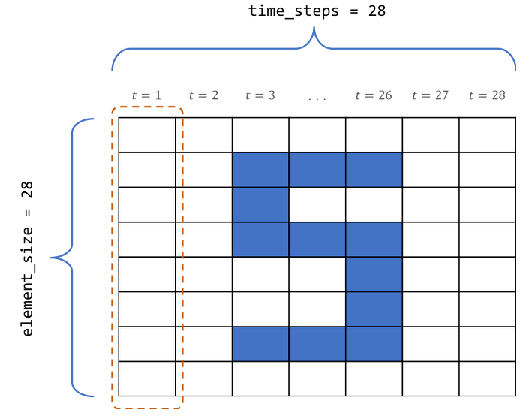

In [27]:
import tensorflow as tf

element_size = 28
time_steps = 28
num_classes = 10
batch_size = 128
hidden_layer_size = 128

# MNIST 데이터 불러오기 위한 함수 정의
def mnist_load():
    (train_x, train_y), (test_x, test_y) = tf.keras.datasets.mnist.load_data()
    # Train set
    train_x = train_x.astype('float32') / 255.
    # Test set
    test_x = test_x.astype('float32') / 255.
    return (train_x, train_y), (test_x, test_y)
# MNIST 데이터 불러오기
(train_x, train_y), (test_x, test_y) = mnist_load()


model = keras.Sequential()
model.add(keras.layers.LSTM((hidden_layer_size), input_shape=(time_steps, element_size)))
model.add(keras.layers.Dense(num_classes))
model.add(keras.layers.Activation('softmax'))
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


model.fit(train_x, train_y, epochs=20, batch_size=batch_size)

results = model.evaluate(test_x, test_y,  verbose=0)
print(f"Test loss:{results[0]}, accuracy:{results[1]}")

Train on 60000 samples
Epoch 1/20
60000/60000 [==============================] - 4s 70us/sample - loss: 0.5330 - accuracy: 0.8286
Epoch 2/20
60000/60000 [==============================] - 3s 50us/sample - loss: 0.1484 - accuracy: 0.9553
Epoch 3/20
60000/60000 [==============================] - 3s 50us/sample - loss: 0.1004 - accuracy: 0.9697
Epoch 4/20
60000/60000 [==============================] - 3s 50us/sample - loss: 0.0773 - accuracy: 0.9766
Epoch 5/20
60000/60000 [==============================] - 3s 50us/sample - loss: 0.0634 - accuracy: 0.9807
Epoch 6/20
60000/60000 [==============================] - 3s 50us/sample - loss: 0.0544 - accuracy: 0.9832
Epoch 7/20
60000/60000 [==============================] - 3s 50us/sample - loss: 0.0408 - accuracy: 0.9874
Epoch 8/20
60000/60000 [==============================] - 3s 49us/sample - loss: 0.0405 - accuracy: 0.9873
Epoch 9/20
60000/60000 [==============================] - 3s 50us/sample - loss: 0.0335 - accuracy: 0.9898
Epoch 10/20
60

### Twitterr 형태소 분석기

In [28]:
!pip install beautifulsoup4
!pip install konlpy

You should consider upgrading via the 'python -m pip install --upgrade pip' command.


You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [1]:
from konlpy.tag import Twitter

twitter = Twitter()
malist = twitter.pos('나는 누구이고 여기는 어디인가.', norm=True, stem=True)
print(malist)

c:\python36\lib\site-packages\konlpy\tag\_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')
c:\python36\lib\site-packages\jpype\_core.py:210: UserWarning: 
-------------------------------------------------------------------------------
Deprecated: convertStrings was not specified when starting the JVM. The default
behavior in JPype will be False starting in JPype 0.8. The recommended setting
for new code is convertStrings=False.  The legacy value of True was assumed for
this session. If you are a user of an application that reported this warning,
please file a ticket with the developer.
-------------------------------------------------------------------------------

  """)


[('나', 'Noun'), ('는', 'Josa'), ('누구', 'Noun'), ('이고', 'Josa'), ('여기다', 'Verb'), ('어디', 'Noun'), ('인가', 'Josa'), ('.', 'Punctuation')]


## 마르코프 체인과 문장생성
* 마르코프 체인 : 과거의 상태와 무관하게 현재의 상태만을 기반으로 다음 상태를 선택
* 마르코프 체인 문장 생성
    1. 문장을 형태소(또는 단어)로 분할
    2. 단어의 전후 단어를 n개씩 모아 딕셔너리 생성
        * 예:n=3) 나는 누구이고 여기는 어디인가
        * [나,는,누구], [는, 누구, 이고], [누구, 이고, 여기], [이고, 여기, 는], [여기, 는, 어디], [는, 어디, 인가]ㅓ
        * 어떤 형태소 다음에 나타날 요소를 선택할 수 있다.
    3. 딕셔너리로 임의의 문장 생성
        * 예) 등록된 예문으로 새 문장 만들기
            * 등록된 문장
                * 개,도,닷새,가,되면,주인,을,안다.
                * 기르던,개,에게,다리,가,물렸다
                * 닭,쫒던,개,지붕,쳐다,보듯,한다
                * 똥,묻은,개,가,겨,묻은,개,나무란다.
            * 개로 시작하는 새 문장
                * 개, 도/에게/지붕/가, 
                * 개가, 되면/물렸다/겨
                * 개가 되면,  주인
                * 개가 되면 주인, 을
                * 개가 되면 주인을,  안다
                * 개가 되면 주인을 안다
* LSTM으로 전후 단어의 연관성을 학습
    * 확률이 높은 단어 선택
    * 자연스런 문장 생성

### 마르코프 체인을 이용한 챗봇 만들기
* Eliza online demo : http://www.masswerk.at/elizabot/
    * 환자 중심 상담 이론 기반
    * 상대의 말을 반복하는 단순한 기능
    * 영어만 가능

##### 필요 라이브러리
* `!pip install beautifulsoup4`
* `!pip install konlpy`
    * 윈도즈: https://needjarvis.tistory.com/224
    * 맥 : 
        * `export MACOSX_DEPLOYMENT_TARGET=10.10`
        * `CFLAGS="-stdlib=libc++" pip install konlpy`


In [3]:
!pip install beautifulsoup4

You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [ ]:
#윈도우즈 인 경우만 실행
!pip install konlpy

In [ ]:
# 맥인 경우만 실행
!CFLAGS="-stdlib=libc++" pip install jpype1
!export MACOSX_DEPLOYMENT_TARGET=10.10
!CFLAGS='-stdlib=libc++' pip install konlpy

### 챗봇 실습

In [116]:
import codecs
from bs4 import BeautifulSoup
import urllib.request
from konlpy.tag import Twitter
import os, re, json, random
dict_file = "../../chatbot-data.json"
dic = {}
twitter = Twitter()
# 딕셔너리에 단어 등록하기 --- (※1)
def register_dic(words):
    global dic
    if len(words) == 0: return
    tmp = ["@"]
    for i in words:
        word = i[0]
        if word == "" or word == "\r\n" or word == "\n": continue
        tmp.append(word)
        if len(tmp) < 3: continue
        if len(tmp) > 3: tmp = tmp[1:]
        set_word3(dic, tmp)
        if word == "." or word == "?":
            tmp = ["@"]
            continue
    # 딕셔너리가 변경될 때마다 저장하기
    json.dump(dic, open(dict_file,"w", encoding="utf-8"))
# 딕셔너리에 글 등록하기
def set_word3(dic, s3):
    w1, w2, w3 = s3
    if not w1 in dic: dic[w1] = {}
    if not w2 in dic[w1]: dic[w1][w2] = {}
    if not w3 in dic[w1][w2]: dic[w1][w2][w3] = 0
    dic[w1][w2][w3] += 1
# 문장 만들기 --- (※2)
def make_sentence(head):
    if not head in dic: return ""
    ret = []
    if head != "@": ret.append(head)        
    top = dic[head]
    w1 = word_choice(top)
    w2 = word_choice(top[w1])
    ret.append(w1)
    ret.append(w2)
    while True:
        if w1 in dic and w2 in dic[w1]:
            w3 = word_choice(dic[w1][w2])
        else:
            w3 = ""
        ret.append(w3)
        if w3 == "." or w3 == "？ " or w3 == "": break
        w1, w2 = w2, w3
    ret = "".join(ret)
    # 띄어쓰기
    params = urllib.parse.urlencode({
        "q": ret
    })
    # 네이버 맞춤법 검사기를 사용합니다.
    try:
        url = "https://m.search.naver.com/p/csearch/ocontent/util/SpellerProxy?where=nexearch&color_blindness=0&" + params
        data = urllib.request.urlopen(url)
        data = data.read().decode("utf-8")
        data = json.loads(data)
        data = data["message"]["result"]["html"]
        data = soup = BeautifulSoup(data, "html.parser").getText()
        # 리턴
    except :
        data = ret
    return data
def word_choice(sel):
    keys = sel.keys()
    return random.choice(list(keys))
# 챗봇 응답 만들기 --- (※3)
def make_reply(text):
    # 단어 학습시키기
    if not text[-1] in [".", "?"]: text += "."
    words = twitter.pos(text)
    register_dic(words)
    # 사전에 단어가 있다면 그것을 기반으로 문장 만들기
    for word in words:
        face = word[0]
        if face in dic: return make_sentence(face)
    return make_sentence("@")
# 딕셔너리가 있다면 읽어 들이기
if os.path.exists(dict_file):
    dic = json.load(open(dict_file,"r"))
    print("dictionary loaded.")
else:
    print("no dictionary. 챗봇 훈련이 필요해요.")

print("대화를 종료하시려면 'exit'를 입력하세요.")
while True:
    txt = input("You :")
    if txt == "exit":
        print("Bye~")
        break
    reply = make_reply(txt)
    print("Bot :%s"%reply)

dictionary loaded.
대화를 종료하시려면 'exit'를 입력하세요.
You :너는 누구니?
Bot :너 때문이야.
You :뭐가 나 때문이야?
Bot :뭐해?
You :졸려서 죽겠어
Bot :졸려서 죽겠어.
You :그치? 졸릴 시간이야.
Bot :졸릴 시간이야.
You :12시가 넘었으니가.
Bot :12시가 넘었으니가.
You :exit
Bye~


## 마르코프 체인과 LSTM을 이용한 문장 자동 생성기 예제
* 박경리 토지 다운로드
    * 국립국어원 : https://ithub.korean.go.kr/user/total/database/corpusView.do?boardSeq=2&articleSeq=2081&boardGb=T&isInsUpd=&boardType=CORPUS
    * ./data/BEXX004.txt
* 필요 라이브러리
    * `!pip install beautifulsoup4`
    * `!pip install konlpy`

In [119]:
import codecs
from bs4 import BeautifulSoup
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import RMSprop
#from tensorflow.keras.utils.data_utils import get_file
import numpy as np
import random, sys

fp = codecs.open("../../data/BEXX0004.txt", "r", encoding="utf-16")
soup = BeautifulSoup(fp, "html.parser")
body = soup.select_one("body")
text = body.getText() + " "
print('코퍼스의 길이: ', len(text))

# 문자를 하나하나 읽어 들이고 ID 붙이기
chars = sorted(list(set(text)))
print('사용되고 있는 문자의 수:', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars)) # 문자 → ID
indices_char = dict((i, c) for i, c in enumerate(chars)) # ID → 문자

# 텍스트를 maxlen개의 문자로 자르고 다음에 오는 문자 등록하기
maxlen = 20
step = 3   # 문장 마다 3글자씩 건너서 생성
sentences = []
next_chars = []

for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])

print('학습할 구문의 수:', len(sentences))
    
print('텍스트를 ID 벡터로 변환합니다...')
X = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

# 모델 구축하기(LSTM)
print('모델을 구축합니다...')
model = Sequential()
model.add(LSTM(128, input_shape=(maxlen, len(chars))))
model.add(Dense(len(chars)))
model.add(Activation('softmax'))
optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

model.fit(X, y, batch_size=128, nb_epoch=30) # 



코퍼스의 길이:  360490
사용되고 있는 문자의 수: 1888
학습할 구문의 수: 120157
텍스트를 ID 벡터로 변환합니다...
모델을 구축합니다...


W1105 00:04:22.538805 49724 training.py:701] The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 120157 samples
Epoch 1/30
120157/120157 [==============================] - 17s 145us/sample - loss: 3.7889
Epoch 2/30
120157/120157 [==============================] - 16s 137us/sample - loss: 3.3360
Epoch 3/30
120157/120157 [==============================] - 17s 138us/sample - loss: 3.2299
Epoch 4/30
120157/120157 [==============================] - 17s 138us/sample - loss: 3.1504
Epoch 5/30
120157/120157 [==============================] - 17s 138us/sample - loss: 3.0718
Epoch 6/30
120157/120157 [==============================] - 17s 138us/sample - loss: 3.0064
Epoch 7/30
120157/120157 [==============================] - 17s 137us/sample - loss: 2.9556
Epoch 8/30
120157/120157 [==============================] - 17s 138us/sample - loss: 2.9152
Epoch 9/30
120157/120157 [==============================] - 17s 137us/sample - loss: 2.8843
Epoch 10/30
120157/120157 [==============================] - 17s 137us/sample - loss: 2.8491
Epoch 11/30
120157/120157 [============================

In [120]:

# 후보를 배열에서 꺼내기
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    ret = np.argmax(probas)
    #print(f"sample {temperature}, {np.argmax(preds)}, {ret}")
    return ret


start_index = random.randint(0, len(text) - maxlen - 1)
generated = ''
sentence = text[start_index: start_index + maxlen]
generated += sentence
print('--- 시드 = "' + sentence + '"')
sys.stdout.write(generated)
# 시드를 기반으로 텍스트 자동 생성
for i in range(400):
    x = np.zeros((1, maxlen, len(chars)))
    for t, char in enumerate(sentence):
        x[0, t, char_indices[char]] = 1.
    # 다음에 올 문자를 예측하기
    preds = model.predict(x, verbose=0)[0]
    next_index = sample(preds)
    #next_index = np.argmax(preds)#sample(preds, diversity)
    next_char = indices_char[next_index]
    # 출력하기
    generated += next_char
    sentence = sentence[1:] + next_char
    sys.stdout.write(next_char)
    sys.stdout.flush()
print()

--- 시드 = " 가만히, 그저 가만히 앉아 있었을 "
 가만히, 그저 가만히 앉아 있었을 때는 바른이나는,"
"그건 지는데?'
자민의 치마있 해어 더 죽 하는 것 같았어. 이마는 홍이를 세편하네, 그러나 삼석이 어선유 모습의 싶여 했다.
"그네가 말굴스"
날심이 그거다. 또 웃는 일이, 거면,"
"그라니, 신일 사람이 따라다지 못 모리겄소."
"가소. 머 얼? 다 참는 말을 마다 상소 속은 부러은 순, 잘추네."
"내부, 우리기하는 만나 같다. 어십니야겄소?"
"나가오느냐!"
간쪽이의 남아 있다.
"제유(었던 것을 공

c:\python36\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


처실인 기르는데, 아아이야 이지해서 집안 문을 안 마시지만 하라서는 잡아돌아을 보아 비없었다. 막아하야 워전에 그까신다. 불했을 망해치는 기라. 일하고 화가를 고장이에 열집이나 나는 분이 싶은 사람의 예사들었던 해요? 식자지 주인상에 가서 그"허 처술!"
"마시음까지 침러진용은 히 




## 텍스트 데이터 다루기
* 텍스트가 가장 흔한 시퀀스 데이타
* 비전이 픽셀에 대한 패턴인식
* 자연어처리는 단어, 문장, 문단에 대한 패턴인식
* 입력데이타는 텍스트 원본일 수 없어서 텍스트 벡터화 필요
    * 텍스트를 단어로 나누고 각 단어를 하나의 벡터로 변환
    * 텍스트를 문자로 나누고 각 문자를 하나의 벡터로 변환

* 어떻게 변환하든 이것을 토큰이라한다.
* 토큰에 수치형 벡터 연결
    * 원핫 인코딩(One-hot encoding)
    * 토큰 임베딩(Token Embbeding)

### One-Hot Encoding
* 토큰을 벡터로 변환하는 가장 일반적인 방법
* 모든 단어(문자)에 고유한 인텍스 부여, 인텍스를 원핫 인코딩
    * 예) I love you
        * I : 0, [1,0,0]
        * love : 1, [0,1,0
        * you : 2, [0,0,1]
* 단점
    * 희소 배열 생성(대부분이 0)        
    * 단어(문자) 수가 많아 지면 차원이 너무 비대해진다.
    * 단어(문자)에 유사도 없음
    * 단어(문자)의 순서에 대한 정보 없음
* keras 원핫인코딩 유틸
    * keras.preprocessing.text.Tokenizer
    

### Token Embbeding - Word2Vec
* 원핫 인코딩 단점 보완
* 밀집, 저차원
* Word2Vec(Skip gram)
* window size에 맞게 이웃하는 단어 선택
* 각 단어를 one-hot encoding으로 변환
* 예) king brave man/ queen beautiful women(window_size=1)
    * king[1,0,0,0,0,0] - brave[0,1,0,0,0,0]
    * brave[0,1,0,0,0,0] - man[0,0,1,0,0,0]
    * brave[0,1,0,0,0,0] - king[1,0,0,0,0,0]
    * queen[0,0,1,0,0,0] - beautiful[0,0,0,0,1,0]
    * beautiful[0,0,0,0,1,0] - women[0,0,0,0,0,1]
    * women[0,0,0,0,0,1] - beautiful[0,0,0,0,1,0]
*  hidden layer가 2인 네트워크에 input과 output으로 전달해서 학습
    * ![](https://i.imgur.com/vjVYupm.png)
* 학습한 W1, W2가 입력 단어에 대한 벡터
   * king[1,1]
   * brave[1,2]
   * man[1,3]
   * queen[5,5]
   * beautiful[5,6]
   * women[5,7]

king-man+women =  [5 5]


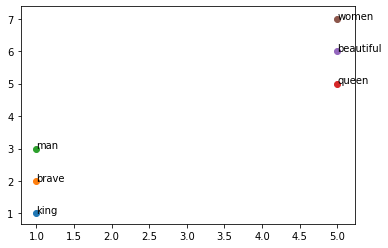

In [87]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

word2vec = {"king":np.array([1,1]), "brave":np.array([1,2]),"man": np.array([1,3]), "queen":np.array([5,5]), "beautiful":np.array([5,6]),"women": [5,7]}
for k, v in word2vec.items():
    plt.annotate(k, v)
    plt.scatter(v[0], v[1])

king_man_women = word2vec['king'] - word2vec['man'] + word2vec['women']    
print("king-man+women = " , king_man_women)


        

###  텍스트 유사도 표현
* Bag of Words
    * 각 단어의 출연 빈도를 표시
* N-gram
    * 텍스트에서 단어나 문자의 n-그램을 추출하여 그것을 하나의 벡터로 변환
        * n-gram: 문장에서 이웃한 N개의 문자
            * 예)"The cat sat on the mat"
            * 2-gram : "The cat", "cat on", "on the", "the mat"
            * 3-gram : "The cat sat", "cat sat on", "sat on the", "on the mat" 

### Word2Vec 구현 예제

In [1]:
corpus = ['king is a strong man', 
          'queen is a wise woman', 
          'boy is a young man',
          'girl is a young woman',
          'prince is a young king',
          'princess is a young queen',
          'man is strong', 
          'woman is pretty',
          'prince is a boy will be king',
          'princess is a girl will be queen']

def remove_stop_words(corpus):
    stop_words = ['is', 'a', 'will', 'be']
    results = []
    for text in corpus:
        tmp = text.split(' ')
        for stop_word in stop_words:
            if stop_word in tmp:
                tmp.remove(stop_word)
        results.append(" ".join(tmp))
    
    return results


corpus = remove_stop_words(corpus) # stop word 제거하기

In [2]:
words = []
for text in corpus:
    for word in text.split(' '):
        words.append(word)

words = set(words)
print(words)

{'pretty', 'wise', 'strong', 'young', 'prince', 'king', 'queen', 'man', 'woman', 'princess', 'girl', 'boy'}


In [3]:
word2int = {}

for i,word in enumerate(words):
    word2int[word] = i

sentences = []
for sentence in corpus:
    sentences.append(sentence.split())
    
WINDOW_SIZE = 2

data = []
for sentence in sentences:
    for idx, word in enumerate(sentence):
        for neighbor in sentence[max(idx - WINDOW_SIZE, 0) : min(idx + WINDOW_SIZE, len(sentence)) + 1] : 
            if neighbor != word:
                data.append([word, neighbor])

In [4]:
import pandas as pd
for text in corpus:
    print(text)

df = pd.DataFrame(data, columns = ['input', 'label'])

king strong man
queen wise woman
boy young man
girl young woman
prince young king
princess young queen
man strong
woman pretty
prince boy king
princess girl queen


In [5]:
df.head(10)

,input,label
0,king,strong
1,king,man
2,strong,king
3,strong,man
4,man,king
5,man,strong
6,queen,wise
7,queen,woman
8,wise,queen
9,wise,woman


In [6]:
word2int

{'pretty': 0,
 'wise': 1,
 'strong': 2,
 'young': 3,
 'prince': 4,
 'king': 5,
 'queen': 6,
 'man': 7,
 'woman': 8,
 'princess': 9,
 'girl': 10,
 'boy': 11}

In [65]:
import tensorflow as tf
import numpy as np

ONE_HOT_DIM = len(words)

# function to convert numbers to one hot vectors
def to_one_hot_encoding(data_point_index):
    one_hot_encoding = np.zeros(ONE_HOT_DIM)
    one_hot_encoding[data_point_index] = 1
    return one_hot_encoding

X = [] # input word
Y = [] # target word

for x, y in zip(df['input'], df['label']):
    X.append(to_one_hot_encoding(word2int[ x ]))
    Y.append(to_one_hot_encoding(word2int[ y ]))

# convert them to numpy arrays
X_train = np.asarray(X).astype(np.float32)
Y_train = np.asarray(Y).astype(np.float32)


# word embedding will be 2 dimension for 2d visualization
EMBEDDING_DIM = 2 
init = tf.initializers.GlorotUniform()
# hidden layer: which represents word vector eventually
W1 = tf.Variable(init([ONE_HOT_DIM, EMBEDDING_DIM]))
b1 = tf.Variable(tf.random.normal([1])) #bias


# output layer
W2 = tf.Variable(init([EMBEDDING_DIM, ONE_HOT_DIM]))
b2 = tf.Variable(tf.random.normal([1]))




In [75]:
epochs = 20000
optimizer = tf.keras.optimizers.SGD(learning_rate=0.05)
for i in range(epochs):
    with tf.GradientTape() as tape:
        hidden_layer = tf.add(tf.matmul(X_train,W1), b1)
        prediction = tf.nn.softmax(tf.add( tf.matmul(hidden_layer, W2), b2))
        cost = tf.reduce_mean(-tf.reduce_sum(Y_train * tf.math.log(prediction), axis=[1]))
        #cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=Y_train, logits=prediction))
    grads = tape.gradient(cost, [W1, b1, W2, b2])
    optimizer.apply_gradients(zip(grads, [W1, b1, W2, b2]))    
    if i % 3000 == 0:
        print('epochs '+str(i)+' cost is : ',cost.numpy())

epochs 0 cost is :  1.8208572
epochs 3000 cost is :  1.7803462
epochs 6000 cost is :  1.7617093
epochs 9000 cost is :  1.7500916
epochs 12000 cost is :  1.7415472
epochs 15000 cost is :  1.7348158
epochs 18000 cost is :  1.7293566


In [76]:
vectors = (W1 + b1).numpy()
vectors

array([[ 2.3429198 ,  4.229043  ],
       [ 2.008568  ,  6.224355  ],
       [ 6.5057473 , -2.3537207 ],
       [ 0.2863797 ,  0.18204665],
       [ 6.538767  ,  0.71853244],
       [ 0.88064116, -0.3848654 ],
       [ 0.31135345,  1.21837   ],
       [ 0.5524962 , -0.4175769 ],
       [-0.20223498,  0.8373843 ],
       [ 0.8127376 ,  3.8330483 ],
       [ 1.4638691 ,  3.3945    ],
       [ 2.259087  , -0.20595431]], dtype=float32)

In [77]:
w2v_df = pd.DataFrame(vectors, columns = ['x1', 'x2'])
w2v_df['word'] = words
w2v_df = w2v_df[['word', 'x1', 'x2']]
w2v_df

,word,x1,x2
0,pretty,2.342920,4.229043
1,wise,2.008568,6.224355
2,strong,6.505747,-2.353721
3,young,0.286380,0.182047
4,prince,6.538767,0.718532
5,king,0.880641,-0.384865
6,queen,0.311353,1.218370
7,man,0.552496,-0.417577
8,woman,-0.202235,0.837384
9,princess,0.812738,3.833048


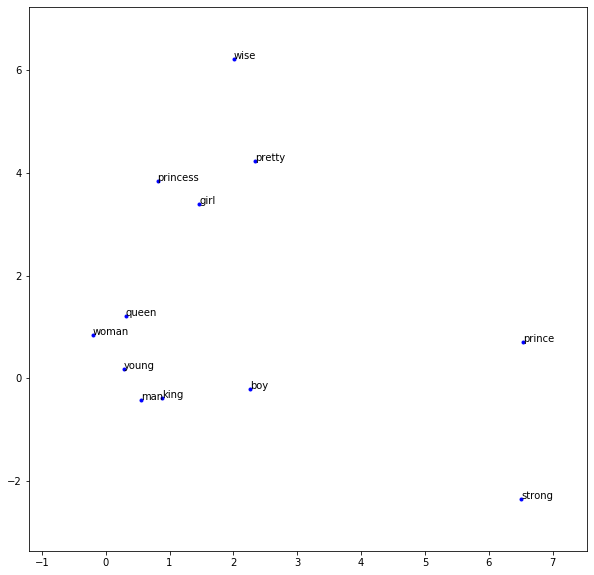

In [78]:
%matplotlib inline
import matplotlib.pyplot as plt

#fig, ax = plt.subplots()
plt.figure(figsize=(10,10))  
for word, x1, x2 in zip(w2v_df['word'], w2v_df['x1'], w2v_df['x2']):
    plt.plot(x1, x2, 'b.')
    plt.annotate(word, (x1,x2 ))
    
      
PADDING = 1.0
x_axis_min = np.amin(vectors, axis=0)[0] - PADDING
y_axis_min = np.amin(vectors, axis=0)[1] - PADDING
x_axis_max = np.amax(vectors, axis=0)[0] + PADDING
y_axis_max = np.amax(vectors, axis=0)[1] + PADDING
 
plt.xlim(x_axis_min,x_axis_max)
plt.ylim(y_axis_min,y_axis_max)

plt.show()
